# Spatial Imaging dv/v
spatial imaging by means of a diffusion-based sensitivity kernel (see Obermann, et al., 2013 and Pacheco and Snieder, 2005)

Implementation here is just for the 2D case

## open values computed from cascadia

### L Curve

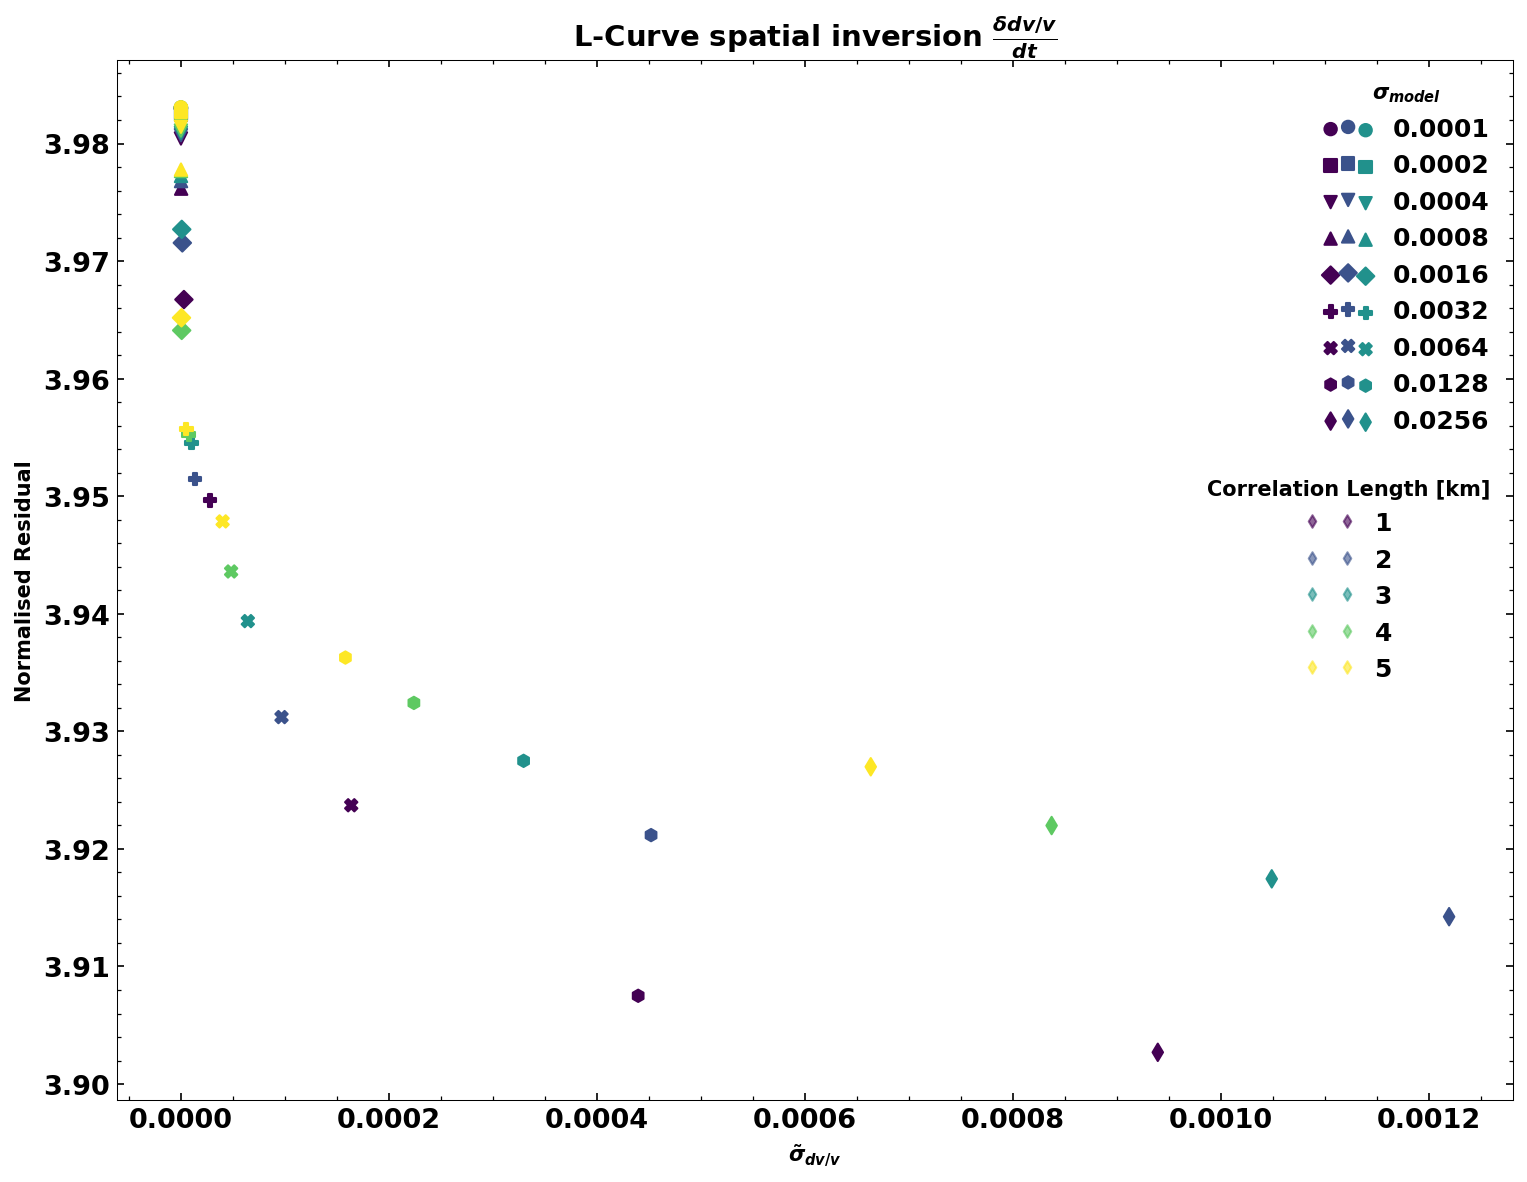

In [63]:
import glob
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from seismic.plot.plot_utils import set_mpl_params

filename = 'Lcurve_0.25'  # input and output


lc = np.load(f'/home/pm/Documents_sync/PhD/StHelens/spatial/kalman/new_gap_handling_tdependent_lcurve_singlecross_allcc_filtereddv/{filename}.npz')
outfolder = '/home/pm/Documents_sync/PhD/StHelens/spatial/figures/lcurves/kalman'
os.makedirs(outfolder, exist_ok=True)
corr_len = lc['corr_len']
std_model = lc['std_model']
corr_lens = np.arange(1, 6, 1)


if 'linearised' in outfolder:
    stds = [5e-4*(2**n) for n in range(10)]
    corrl_grid, stdg = np.meshgrid(corr_lens, stds)
    corrl_grid = corrl_grid.flatten()
    stdg = stdg.flatten()
    residual = lc['residual'][:-10]
    model_variance = lc['model_variances'][:-10]
    residual[stdg==0.016] /= 2
    residual[stdg==0.064] /= 2
    model_variance[stdg==0.016] /= 2
    model_variance[stdg==0.064] /= 2
else:
    stds = [1e-4*(2**n) for n in range(9)]
    corrl_grid, stdg = np.meshgrid(corr_lens, stds)
    corrl_grid = corrl_grid.flatten()
    stdg = stdg.flatten()
    residual = lc['residual']
    model_variance = lc['model_variances']


times = lc['times']
vel_changedt = lc['vel_change']

# residual[residual==0] = np.nan
# thsi is the model variance for the first derivative of dv/v
# model_variance[residual==0] = np.nan


xax = len(corr_len)

# vel_change_total = np.sum(vel_changedt, axis=1)
# vel_change_total = np.reshape(vel_change_total, (xax, -1))



# vel_change = np.cumsum(vel_changedt, axis=1)
# vel_change = np.reshape(vel_change, (xax, len(times), -1))

# compute the model variance for vel_change
# model_variance_dv = np.var(vel_change, axis=-1)



# change shape so that, the grid shape disappears

# residual = np.reshape(lc['residual'], (5, 6)).Tj
# corr_len = np.reshape(lc['corr_len'], (5, 6)).T
# std_model = np.reshape(lc['std_model'], (5, 6)).T
# model_variance = np.reshape(lc['model_variances'], (5, 6)).T

set_mpl_params()

# 6 colours, 5 shapes
plt.figure(figsize=(12, 9))
ax = plt.gca()

markerdict = {k: v for k, v in zip(np.sort(np.unique(stdg)), ['o', 's', 'v', '^', 'D', 'P', 'X', 'h', 'd', '*'])}
# actually mathematically correct is to plot the L2 norm of the model
# against the L2 norm of the residual
for stdm in np.sort(np.unique(stdg)):
    scatter = plt.scatter(np.nanmedian(model_variance, axis=-1)[stdg==stdm], np.nanmedian(residual, axis=-1)[stdg==stdm], c=np.array(corrl_grid)[stdg==stdm], s=35, marker=markerdict[stdm], label=stdm)
# plot with varying markers
# for marker in set(markers):
    # i = np.where(np.array(markers) == marker)
    # scatter = plt.scatter(np.nanmean(np.sqrt(model_variance), axis=-1)[i], np.nanmean(residual, axis=-1)[i], c=np.array(corr_len)[i], s=35, marker=marker, label=std_model[i][0])

    # scatter = plt.scatter(np.nanmean(np.sqrt(np.mean(vel_change**2, axis=-1)), axis=-1)[i], np.nanmean(residual, axis=-1)[i], c=np.array(corr_len)[i], s=35, marker=marker, label=std_model[i][0])

    # scatter = plt.scatter(np.nanmean(model_variance, axis=-1)[i], np.nanmean(residual, axis=-1)[i], c=np.array(corr_len)[i], s=35, marker=marker, label=std_model[i][0])



# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Correlation Length [km]")
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend1 = ax.legend(handles, labels, loc="center right", title="Correlation Length [km]")
ax.add_artist(legend1)

# produce a legend with a cross-section of sizes from the scatter
# handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
# legend2 = ax.legend(handles, size_id, loc="upper right", title=r"$\sigma_{model}$")
plt.legend(loc='upper right', title=r"$\sigma_{model}$")


plt.title(r'L-Curve spatial inversion $\frac{\delta dv/v}{dt}$')
plt.ylabel('Normalised Residual')
plt.xlabel(r'$\tilde\sigma_{dv/v}$')
# plt.xlabel('Max vel-change change (%)')


# plot log log
# plt.xscale('log')
# plt.yscale('log')

# plt.xlim((0, None))
plt.savefig(f'{outfolder}/{filename}.pdf', bbox_inches='tight', facecolor='None')

In [64]:
# Time dependent Lcurve
import os

from obspy import UTCDateTime

outfolder = os.path.join(outfolder,'tdependent')
os.makedirs(outfolder, exist_ok=True)

vel_changedt = np.reshape(vel_changedt, (xax, len(times), -1))

for ii, time in enumerate(times):
    if np.all(np.isnan(residual[:, ii])):
        continue
    # if np.all(residual[:, ii]==0):
    #     continue
    plt.figure(figsize=(12, 9))
    ax = plt.gca()
    # actually mathematically correct is to plot the L2 norm of the model
    # against the L2 norm of the residual
    # scatter = plt.scatter(np.sqrt(np.mean(vel_change_total**2, axis=-1)), np.nanmean(residual, axis=-1), c=corr_len, s=sizes)

    # plot with varying markers
    for stdm in np.sort(np.unique(stdg)):
        scatter = plt.scatter(
            model_variance[stdg==stdm][:,ii], residual[stdg==stdm][:,ii],
            c=np.array(corrl_grid)[stdg==stdm], s=35, marker=markerdict[stdm],
            label=stdm)


    # # 3. plot that point
    # plt.scatter(xq[max_curvature], fit_func(xq[max_curvature], *popt), marker='x', s=100, color='red', alpha=.5)

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="Correlation Length [km]")
    handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
    legend1 = ax.legend(handles, labels, loc="center right", title="Correlation Length [km]")
    ax.add_artist(legend1)

    # produce a legend with a cross-section of sizes from the scatter
    plt.legend(loc='upper right', title=r"$\sigma_{model}$")

    # handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
    # legend2 = ax.legend(handles, size_id, loc="upper right", title=r"$\sigma_{model}$")
    plt.title(r'L-Curve spatial inversion $\frac{\delta dv/v}{dt}$')
    plt.ylabel('Normalised Residual')
    plt.xlabel('Standard deviation dv/v')
    # plot log log
    # plt.xscale('log')
    # plt.yscale('log')
    # plt.xlim((0, None))
    plt.savefig(
        f'{outfolder}/{filename}_{UTCDateTime(time)}.png',
        bbox_inches='tight', facecolor='None', dpi=200)
    plt.close()

### Gridded Time-Series

In [19]:
import glob
import os

import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from obspy import UTCDateTime
from scipy.signal import butter, sosfiltfilt, detrend




freq0 = 0.25
corr_len = 2
std_model = 0.0016

infile = glob.glob(
    f'/home/pm/Documents_sync/PhD/StHelens/spatial/kalman_1.0_fadingmem/new_gap_handling_crosssingle_largemap_cl{corr_len}_stdm{std_model}/{freq0}-*/dvdt_3D.npz')[0]
# infile = glob.glob(
    # f'/home/pm/Documents_sync/PhD/StHelens/spatial/linearised/new_gap_handling_crosssingle_dvfilt_allcc_cl{corr_len}_std{std_model}_largemap/{freq0}-*/dvdt_3D.npz')[0]

# infile = glob.glob(
    # f'/home/pm/Documents_sync/PhD/StHelens/spatial/twsvd/new_gap_handling_crosssingle_025_largemap/{freq0}-{freq0*2}/dvdt_3D.npz')[0]

outfolder = os.path.join(os.path.dirname(os.path.dirname(infile)), 'figures')
os.makedirs(outfolder, exist_ok=True)

loaded = np.load(infile)

x = loaded['xaxis']
y = loaded['yaxis']
t = loaded['taxis']
dvdt = loaded['dv']
# Filter requirements.
# order = 6
# fs = 1/np.median(np.diff(t))       # sample rate, Hz
# cutoff = 1/250  # desired cutoff frequency of the filter, Hz
# # Get the filter coefficients so we can check its frequency response.
# sos = butter(order, cutoff, btype='high', analog=False, output='sos', fs=1)
# # extract the linear trend and keep it
# dvdt = np.nan_to_num(dvdt)
# trend = dvdt - detrend(dvdt, axis=-1)


# dvdt = sosfiltfilt(sos, np.nan_to_num(dvdt), axis=-1)
# dvdt += trend

statx = loaded['statx']
staty = loaded['staty']
# No data anymore from this date on
start = 0  # 4 for february # Start here for February
start = np.argmin(abs(t - UTCDateTime('2007-06-01').timestamp))
end = -1
# note that this are rows -> latitude, columns -> longitude, pages -> time
dvdt = dvdt[:,:,start:]
t = t[start:]
try:
    res = loaded['resolution']
except KeyError:
    res = None
# t = t[start:end]

# Integrate to plot dv/v
# trapz doesn't work with nans
# options
# 1. manual integration
# 2. replace nans with interpolation? Otherwise this is probably not correct
# 
nani = ~np.isnan(dvdt[0,0,:])
# We start here to have February to February

# Total dv change over the whole time
if 'ddt' not in infile:
    dv_total = dvdt[:, :, -1]
    dv = np.nan_to_num(dvdt)
else:
    dv_total = np.nansum(dvdt, axis=-1)
    dv = np.nancumsum(dvdt, axis=-1)

# minmax
# dv_total = -abs(dv.max(axis=-1)-dv.min(axis=-1))

# # # seasonal
# # # average of change from January to July is <7 and the other is >6
# # Probably necessary to do a linear detrend to make sense of this
# # for detrend just remove the mean of the derivative
# dvdt_demean = dvdt - np.reshape(np.nanmean(dvdt, axis=-1), (36, 34, 1))
utcs = [UTCDateTime(tt) for tt in t]
datetimes = [utci.datetime for utci in utcs]

# indices = []
# for year in {UTCDateTime(tt).year for tt in t}:
#     indices.append(np.array([(utc.month<=6 and utc.year==year) for utc in utcs]))

# dv_total = np.nanmean([np.nansum(dvdt_demean[:, : ,ii], axis=-1) for ii in indices], axis=0)

# # before and after eruption
# print(utcs[255])
# print(utcs[401])
# dv_total = np.nansum(dvdt[:,:,255:401], axis=-1)

# # Up to eruption
# print(utcs[0])
# print(utcs[219])
# dv_total = np.nansum(dvdt[:,:,0:219], axis=-1)

# # and finally, from eruption end to now

# dv_total = np.nansum(dvdt[:,:,392:], axis=-1)

# # haida eq 28.10.2012
# # print(utcs[540:544])
# dv_total = np.nansum(dvdt[:,:,540:544], axis=-1)



# Name suffix for output figure
output_param = 'total'

# dvdt = np.nan_to_num(dvdt)

IndexError: list index out of range

### Show dv/v time series at one point

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


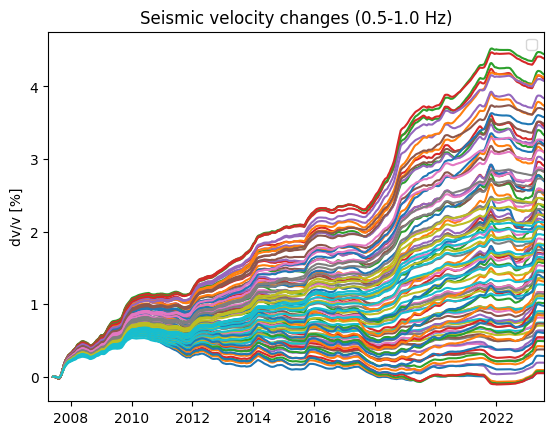

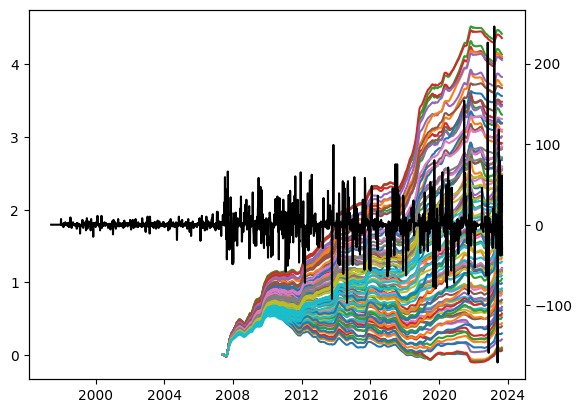

In [16]:
import datetime
# load numpy archives with data availability
loaded= np.load(f'/home/pm/Documents_sync/PhD/StHelens/dv/new_gap_handling/availability_{freq0}.npz', allow_pickle=True)
avail_t = loaded['t']
avail_n = loaded['n']

avail_nd = np.hstack((0, np.diff(avail_n)))
# remove the peak at the end
avail_nd[np.argmin(avail_nd)] = 0

# plt.plot(datetimes, -100*dv[17, 20, :], label='MSH summit')
# plt.plot(datetimes, -100*dv[20, 12, :], label='loc of maximum dv/v increase')
for ii in range(10):
    ii += 10
    for jj in range(10):
        jj += 10
        plt.plot(datetimes, -100*dv[ii, jj, :])
ax1 = plt.gca()
# plot data availability as bars on second y axis


# ax2.set_ylim([0, 500])
# ax1.set_ylim([-3, 4])

plt.xlim([datetime.datetime(2007, 4, 1), datetime.datetime(2023, 8, 1)])
ax1.set_ylabel('dv/v [%]')
plt.title(f'Seismic velocity changes ({freq0}-{freq0*2} Hz)')
plt.legend()

plt.savefig(os.path.join(outfolder, f'dvv1d_{freq0}.pdf'), bbox_inches='tight', transparent=True)

plt.figure()
for ii in range(10):
    ii += 10
    for jj in range(10):
        jj += 10
        plt.plot(datetimes, -100*dvdt[ii, jj, :])
ax1 = plt.gca()
ax2 = plt.twinx()
ax2.plot(avail_t, avail_nd, color='k')

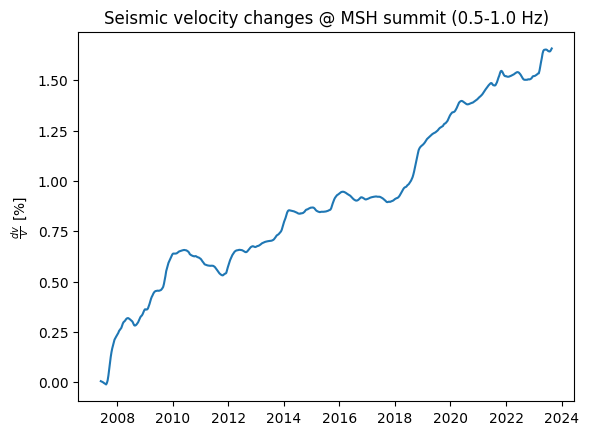

In [17]:

plt.plot(datetimes, -100*dv[15, 19, :], label='MSH summit')
plt.ylabel(r'$\frac{dv}{v}$ [%]')
plt.title(f'Seismic velocity changes @ MSH summit ({freq0}-{freq0*2} Hz)')
plt.savefig(os.path.join(outfolder, f'dvv1d_{freq0}_summit.png'), dpi=300, bbox_inches='tight', transparent=True)


(-2.0, 2.0)

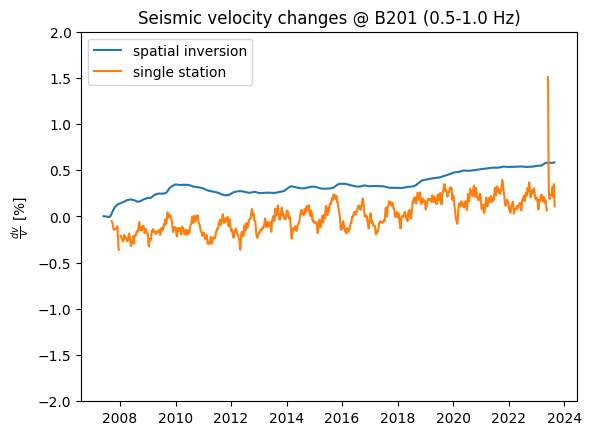

In [18]:
import dateutil
from seismic.monitor.dv import read_dv
from obspy.geodetics import degrees2kilometers as d2km
from obspy.geodetics import locations2degrees as loc2deg

# compare to single station result from PB B201 EH1-EH2
infile = f'/home/pm/Documents_sync/PhD/StHelens/dv/new_gap_handling/betweenComponents*_{freq0}-{freq0*2}*/DV-PB-PB.B201-B201.EH1-EH2.npz'
dv_single = read_dv(infile)[0]
# Find coordinates on the grid

stla = dv_single.stats.stla
sty = d2km(stla)
stlo = dv_single.stats.stlo
stx = -d2km(loc2deg(46.05, 0, 46.05, stlo))
# Find the closest grid point
ix = np.argmin(abs(stx-x))
iy = np.argmin(abs(sty-y))

plt.plot(datetimes, -100*dv[ix, iy, :], label='spatial inversion')
plt.plot(
    [_t.datetime for _t in dv_single.stats.corr_start], -100*dv_single.value,
    label='single station')
plt.legend()
plt.ylabel(r'$\frac{dv}{v}$ [%]')
plt.title(f'Seismic velocity changes @ B201 ({freq0}-{freq0*2} Hz)')
plt.savefig(os.path.join(outfolder, f'dvv1d_{freq0}_B201.png'), dpi=300, bbox_inches='tight', transparent=True)
plt.ylim((-2, 2))


#### Plot this using PyGMT

In [12]:
# interpolate the data from the algorithm, back onto lat and lon
from obspy.geodetics import kilometer2degrees as km2d
from obspy.geodetics import degrees2kilometers as d2km
from obspy.geodetics import locations2degrees as loc2d
from xarray import DataArray
import pygmt


lat = km2d(y)
lat0 = lat.min()
lon0 = -122.45 # -122.34
# find out how many degree 1km is
km2lon = 1/d2km(loc2d(lat0, 1, lat0, 0))
lon = km2lon*(x-x.min())+lon0

region = [lon.min(), lon.max(), lat.min(), lat.max()]
topo = pygmt.datasets.load_earth_relief(resolution="03s", region=region)
# topo is returned as lines are latitude and columns longitude


pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from -122.022384584 to -122.021666667
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from 46.3647625621 to 46.365


In [13]:
from scipy.interpolate import RegularGridInterpolator

latq = topo.coords['lat'].data
lonq = topo.coords['lon'].data


lonqg, latqg = np.meshgrid(lonq, latq)
qcoords = np.array([np.array([la, lo]) for lo, la in zip(lonqg.flatten(), latqg.flatten())])

f = RegularGridInterpolator((lat, lon), dv_total, bounds_error=False, method='linear')

dv_totalint = f(qcoords)
dv_totalint = dv_totalint.reshape(latqg.shape)

dv_total_grid = DataArray(data=dv_totalint*-100, coords={'lon': lonq, 'lat': latq}, dims=('lat', 'lon'), name='dv/v')
print(-dv_total.min()*100, -dv_total.max()*100)

9.388899119945327 -7.477355150863774


In [14]:
# pygmt.config() #'13p')
import os
import pandas as pd

stats = pd.read_csv('stat_locs.txt', sep='|', header=0, skipinitialspace=True)


fig = pygmt.Figure()
# create colorbar for xarray.DataArray
absmax = np.max(abs(dv_total))
pygmt.makecpt(
    # cmap="red,white,blue",
    cmap='batlow',
    series=f"{-dv_total.max()*100}/{absmax*100+.01}",
    continuous=True,
    reverse=False,
)

persp = [160, 30] #40
persp = [180, 90] #40

proj = "M30c"

cb_tick_increment = round(
    (dv_total.max() - dv_total.min())*100/7,
    int(-np.floor(np.log10(100*(dv_total.max() - dv_total.min()))) + 1))

surftype = 'i'
with pygmt.config(
    MAP_FRAME_TYPE='fancy+', FORMAT_GEO_MAP='ddd.xx',
    # MAP_GRID_CROSS_SIZE_PRIMARY=0.20,
    # MAP_GRID_CROSS_SIZE_SECONDARY=0.20,
    # MAP_TICK_LENGTH_PRIMARY=0.5,
    # MAP_TICK_LENGTH_SECONDARY=0.5,
    # FONT_ANNOT_PRIMARY='18p,Helvetica-Bold',
    # FONT_ANNOT_SECONDARY='18p,Helvetica-Bold',
        FONT='25p,Helvetica-Bold'):
    dgrid = pygmt.grdgradient(grid=topo, radiance=[270, 1])
    # add contour lines
    
    fig.grdimage(
        grid=dv_total_grid,
        # Sets the view azimuth as 130 degrees, and the view elevation as 30
        # degrees
        perspective=persp, #160 50
        region=region,
        # Sets the x- and y-axis labels, and annotates the west, south, and east
        # axes
        frame=["xa", "ya", "WSnE"],
        # shading=dgrid,
        # surftype='sm',#m0.01p',
        # cmap='rainbow',
        # plane="2000+gblack",
        # Sets a Mercator projection on a 15-centimeter figure
        projection=proj,
        # Sets the height of the three-dimensional relief centimeters
        # meshpen="0,150",
        transparency=30,
        interpolation='n'
    )
    fig.grdcontour(
        annotation=1000,
        interval=250,
        grid=topo,
    )
    # fig.grdview(
    #     grid=topo,
    #     drapegrid=dv_total_grid,
    #     # Sets the view azimuth as 130 degrees, and the view elevation as 30
    #     # degrees
    #     perspective=persp, #160 50
    #     region=region,
    #     # Sets the x- and y-axis labels, and annotates the west, south, and east
    #     # axes
    #     frame=["xa", "ya", "WSnE"],
    #     # surftype='sm',#m0.01p',
    #     surftype=surftype,
    #     # cmap='rainbow',
    #     # plane="2000+gblack",
    #     # Sets a Mercator projection on a 15-centimeter figure
    #     projection=proj,
    #     # Sets the height of the three-dimensional relief centimeters
    #     zsize="4c",
    #     # meshpen="0,150",
    #     meshpen="0.1p",
    #     contourpen="0.1p,black",
    #     transparency=0,
    #     interpolation='n'
    # )
    fig.colorbar(frame=[f'a{cb_tick_increment}', "x+ldv/v", "y+l[%]"], projection=proj)
    fig.plot(
        x=stats.Longitude, y=stats.Latitude, style="i0.7c", color="red", pen="black", transparency=25, projection=proj)
fig.savefig(f'{outfolder}/dvv_map_{output_param}_{freq0}-{freq0*2}_{surftype}_contour075.png', dpi=300, transparent=True)

makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)


## SVD on the time series
Find dominant components in time and space-domain. Perhaps the inversion can
be reduced to fewer parameters?

In [ ]:
from scipy.linalg import svd, diagsvd
U, S, Vh = np.linalg.svd(dv, full_matrices=False)

print(dv.shape)
print(S.size)

# approximate dv with the the singular values above .5
S[S<.25] = 0
print(S.nonzero()[0].size)
dv_approx = np.matmul(U * S[..., None, :], Vh)



(36, 34, 594)
1224
36


In [ ]:
print(dv.size)
print(S.nonzero()[0].size, Vh.size)

727056
36 727056


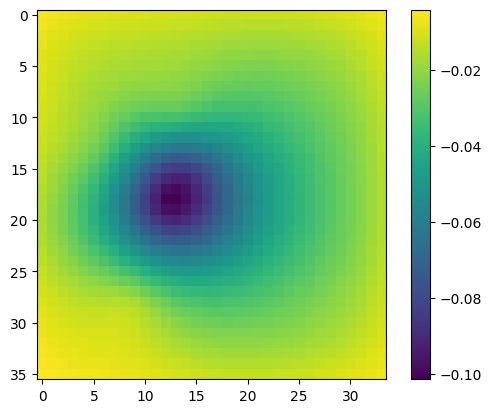

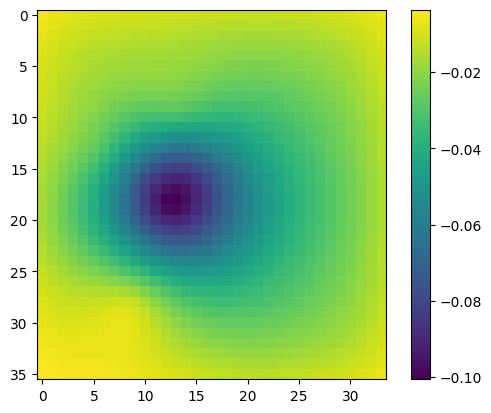

In [ ]:
plt.imshow(dv_approx[:,:,-1])
plt.colorbar()
plt.figure()
plt.imshow(dv[:,:,-1])
plt.colorbar()

## dv/v time series video

In [8]:
# get events
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy.core.event.catalog import Catalog
import numpy as np
from obspy import read_events


minmag = 0
try:
    evts = read_events(f'MSH_events_minmag{minmag}.xml')
except FileNotFoundError:
    c = Client('USGS', timeout=240)

    lat = [45.95, 46.45]
    lon = [-122.45, -121.96]


    starttime = UTCDateTime(year=2007, julday=1)
    endtime = UTCDateTime(year=2023, julday=300)
    delta = 86400*365
    rtimes = np.linspace(starttime.timestamp, endtime.timestamp, 12)
    # rtimes = np.arange(starttime.timestamp, endtime.timestamp, delta)
    evts = Catalog()



    for ii, rtime in enumerate(rtimes):
        if ii == len(rtimes)-1:
            break
        start = UTCDateTime(rtime)
        end = UTCDateTime(rtimes[ii+1])
        print(f'downloading events from {start} to {end}')
        evts.extend(c.get_events(
            starttime=start, endtime=end, minmagnitude=minmag, maxdepth=15,
            minlatitude=lat[0], maxlatitude=lat[1], minlongitude=lon[0],
            maxlongitude=lon[1]))
    evts.write(f'MSH_events_minmag{minmag}.xml', format='QUAKEML')

otimes = [evt.preferred_origin().time.datetime for evt in evts]
hypz = [-evt.preferred_origin().depth for evt in evts]
hyplats = [evt.preferred_origin().latitude for evt in evts]
hyplons = [evt.preferred_origin().longitude for evt in evts]

In [10]:

# load gps movements to plot vertical offset
import os
import glob
import pandas as pd
import datetime
from obspy.signal.filter import highpass
from scipy.signal import detrend

infiles = glob.glob('/home/pm/Documents_sync/PhD/StHelens/gnss_data/*.pos')

positions = {}

for infile in infiles:
    # retrieve station name
    station = os.path.basename(infile).split('.')[0]
    # retrieve GPS position and time dependent height
    df = pd.read_csv(infile, skiprows=36, delim_whitespace=True, usecols=[0,2,12,13, 14, 17])
    # create new date column
    df['date'] = pd.to_datetime(df['*YYYYMMDD'], format='%Y%m%d')
    try:
        tii = np.where(abs(df['date']-datetimes[0])<datetime.timedelta(days=1))[0][0]
    except IndexError:
        print(f'No data for {station}')
        continue
    # create vertical offset relative to first day
    positions[station] = df
    # 30d mean
    # extract linear trend
    values = positions[station]['dU'].values
    # gps_detrend = detrend(values, type='linear')
    # trend = values - gps_detrend
    # positions[station]['dU_hpass'] = highpass(values, 1/500, 1, corners=4, zerophase=True)
    # remove outliers
    
    positions[station]['dU_smoothed'] = positions[station]['dU'].rolling(30).mean()
    positions[station]['dU_smoothed'] = positions[station]['dU_smoothed'].mask(np.abs(positions[station]['dU_smoothed']) > 0.1)
    # positions[station]['dU_smoothed'] += trend

    # Set value at first day to zero
    positions[station]['dU_smoothed'] -= positions[station]['dU_smoothed'][tii]

    # enter station coordinates
    positions[station]['lat'] = positions[station]['NLat'][0]
    positions[station]['lon'] = positions[station]['Elong'][0]
    # values = positions[station]['dU_smoothed'].values
    # gps_detrend = detrend(values, type='linear')
    # df = 1/(df['date'][1]-df['date'][0]).total_seconds()
    # positions[station]['dU_hpf']= highpass(
    #     gps_detrend, filtfreq, df, corners=4, zerophase=True)

No data for P699
No data for P704


In [11]:
# interpolate the data from the algorithm, back onto lat and lon
from obspy.geodetics import kilometer2degrees as km2d
from obspy.geodetics import degrees2kilometers as d2km
from obspy.geodetics import locations2degrees as loc2d
from xarray import DataArray
import pygmt


lat = km2d(y)
lat0 = lat.min()
lon0 = -122.45 # -122.34
# find out how many degree 1km is
km2lon = 1/d2km(loc2d(lat0, 1, lat0, 0))
lon = km2lon*(x-x.min())+lon0

region = [
    lon.min(), lon.max(),
    lat.min(), lat.max()]
topo = pygmt.datasets.load_earth_relief(resolution="15s", region=region)
# topo is returned as lines are latitude and columns longitude


pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from -122.022384584 to -122.020833333
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from 46.3647625621 to 46.3666666667


In [12]:
# pygmt.config() #'13p')
import os
import datetime
from turtle import position
import pandas as pd
from scipy.interpolate import RegularGridInterpolator

stats = pd.read_csv('stat_locs.txt', sep='|', header=0, skipinitialspace=True)
stats['starttime'] = [UTCDateTime(s).datetime for s in stats.StartTime]
stats['endtime'] = [UTCDateTime(s).datetime for s in stats.EndTime]

latq = topo.coords['lat'].data
lonq = topo.coords['lon'].data
lonq = np.linspace(lonq.min(), lonq.max(), 102)
latq = np.linspace(latq.min(), latq.max(), 75)
lonqg, latqg = np.meshgrid(lonq, latq)
qcoords = np.array([np.array([la, lo]) for lo, la in zip(lonqg.flatten(), latqg.flatten())])


# create colorbar for xarray.DataArray
absmax = np.max(abs(dv))
pygmt.makecpt(
    cmap='batlow',#"red,white,blue",
    series=f"0/{absmax*100+.01}",
    continuous=True,
    reverse=False,
)

persp = [160, 60] #40
proj = "M30c"

cb_tick_increment = round(
    (dv.max() - dv.min())*100/7,
    int(-np.floor(np.log10(100*(dv.max() - dv.min()))) + 1))
# cb_tick_increment = 0.1

surftype = 'sm'
for date in datetimes[-3:]:
    fig = pygmt.Figure()
    ii = np.argmin(abs(date - np.array(datetimes)))
    f = RegularGridInterpolator(
        (lat, lon), dv[:, :, ii], bounds_error=False, method='linear', fill_value=0)

    

    dv_totalint = f(qcoords)
    dv_totalint = dv_totalint.reshape(latqg.shape)

    dv_grid = DataArray(data=np.squeeze(dv_totalint)*-100, coords={'lon': lonq, 'lat': latq}, dims=('lat', 'lon'), name='dv/v')
    # dv_grid = DataArray(data=np.squeeze(dv[:, :, ii])*-100, coords={'lon': lon, 'lat': lat}, dims=('lat', 'lon'), name='dv/v')
    with pygmt.config(
        MAP_FRAME_TYPE='fancy+', FORMAT_GEO_MAP='ddd.xx',
        # MAP_GRID_CROSS_SIZE_PRIMARY=0.20,
        # MAP_GRID_CROSS_SIZE_SECONDARY=0.20,
        # MAP_TICK_LENGTH_PRIMARY=0.5,
        # MAP_TICK_LENGTH_SECONDARY=0.5,
        # FONT_ANNOT_PRIMARY='18p,Helvetica-Bold',
        # FONT_ANNOT_SECONDARY='18p,Helvetica-Bold',
        FONT='25p,Helvetica-Bold'):
        fig.grdimage(
            grid=dv_grid,
            # Sets the view azimuth as 130 degrees, and the view elevation as 30
            # degrees
            region=region,
            # Sets the x- and y-axis labels, and annotates the west, south, and east
            # axes
            frame=["xa", "ya", "WSnE"],
            # shading=dgrid,
            # surftype='sm',#m0.01p',
            # cmap='rainbow',
            # plane="2000+gblack",
            # Sets a Mercator projection on a 15-centimeter figure
            projection=proj,
            # Sets the height of the three-dimensional relief centimeters
            # meshpen="0,150",
            transparency=30,
            interpolation='n'
        )
        fig.grdcontour(
            annotation=1000,
            interval=250,
            grid=topo,
        )
        # fig.grdview(
        #     grid=topo,
        #     drapegrid=dv_grid,
        #     # Sets the view azimuth as 130 degrees, and the view elevation as 30
        #     # degrees
        #     perspective=persp, #160 50
        #     region=region,
        #     # Sets the x- and y-axis labels, and annotates the west, south, and east
        #     # axes
        #     frame=[f"+t{date}", "xa", "ya"],
            
        #     # surftype='sm',#m0.01p',
        #     surftype=surftype,
        #     # cmap='rainbow',
        #     # plane="2000+gblack",
        #     # Sets a Mercator projection on a 15-centimeter figure
        #     projection=proj,
        #     # Sets the height of the three-dimensional relief centimeters
        #     zsize="4c",
        #     # meshpen="0,150",
        #     meshpen="0.1p",
        #     # contourpen="0.1p,black",
        #     transparency=20,
        #     interpolation='n'
        # )
        fig.colorbar(
            frame=[f'a{cb_tick_increment}', "x+ldv/v", "y+l[%]"],
            projection=proj)
        # plot stations activate at this time
        for stat in stats.loc[
                (stats.starttime<date) & (stats.endtime>date)].Station:
            fig.plot(
                x=stats.loc[stats.Station==stat].Longitude,
                y=stats.loc[stats.Station==stat].Latitude,
                style="i0.85c", color="red", pen="black", transparency=25,
                projection=proj)

        # plot all events that ocurred in the previous 10 days
        # for ot, hz, hyplon, hyplat in zip(otimes, hypz, hyplons, hyplats):
        #     if ot-date > datetime.timedelta(days=-10) and ot-date < datetime.timedelta(days=0):
        #         fig.plot(
        #             x=hyplon, y=hyplat, style="c0.3c", color="purple",
        #             pen="black", transparency=25, projection=proj)
        # plot vertical offset
        pygmt.makecpt(cmap="SCM/bam", series=[-.025, 0.025])
        gnssx = []
        gnssy = []
        gnssz = []
        for station in positions.keys():
            tii = np.argmin(abs(positions[station]['date']-date))
            gnssx.append(positions[station]['lon'].values[0])
            gnssy.append(positions[station]['lat'].values[0])
            gnssz.append(positions[station]['dU_smoothed'].values[tii])
        # plot vertical ground motion as squares

        fig.plot(
            x=gnssx,
            y=gnssy,
            cmap=True,
            color=gnssz,
            style="s0.9c",
            pen="black",
            projection=proj
        )
        # put the colorbar for the vertical offset
        # left of the plot, centered, and vertical
        # move colorbar further left
        fig.colorbar(
            frame="af+lvertical offset (m)", projection=proj,
            position="JML/5c+v+o3c/0c")#/0c+w5c/0.5c+h")
    os.makedirs(f'{outfolder}/video_{freq0}', exist_ok=True)
    # fig.savefig(f'{outfolder}/video_{freq0}/{date}.jpg', dpi=70)
    fig.savefig(f'{outfolder}/video_{freq0}/{date}.png', dpi=300, transparent=True)

makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)


In [11]:
# rename jpg files so they are named 001.jpg, 002.jpg, etc.
import glob
import os
import shutil
import imageio.v3 as iio
import glob

files = glob.glob(f'{outfolder}/video_{freq0}/*.jpg')
files.sort()
for ii, file in enumerate(files):
    shutil.move(file, f'{outfolder}/video_{freq0}/{ii:03d}.jpg')
# create gif from the images above


frames = np.stack([iio.imread(f"{outfolder}/video_{freq0}/{str(x).zfill(3)}.jpg") for x in range(1, 594)], axis=0)

iio.imwrite(f'{outfolder}/video_{freq0}/dvv.gif', frames, duration=0.1)

## Resolution video

In [ ]:
# pygmt.config() #'13p')
import os
import datetime
import pandas as pd
from scipy.interpolate import RegularGridInterpolator
from pygmt import session_management

session_management.end()
session_management.begin()

stats = pd.read_csv('stat_locs.txt', sep='|', header=0, skipinitialspace=True)
stats['starttime'] = [UTCDateTime(s).datetime for s in stats.StartTime]
stats['endtime'] = [UTCDateTime(s).datetime for s in stats.EndTime]
latq = topo.coords['lat'].data
lonq = topo.coords['lon'].data
lonq = np.linspace(lonq.min(), lonq.max(), 102)
latq = np.linspace(latq.min(), latq.max(), 75)
lonqg, latqg = np.meshgrid(lonq, latq)
qcoords = np.array([np.array([la, lo]) for lo, la in zip(lonqg.flatten(), latqg.flatten())])


# create colorbar for xarray.DataArray
pygmt.makecpt(
    cmap="google/turbo",
    series=f"0/2/0.1",
    continuous=True,
    reverse=False,
    # truncate=[0.5, np.nan]
)

persp = [160, 60] #40
proj = "M30c"

cb_tick_increment = 0.25
# cb_tick_increment = 0.1

surftype = 'sm'
for date in datetimes:
    fig = pygmt.Figure()
    ii = np.argmin(abs(date - np.array(datetimes)))
    f = RegularGridInterpolator(
        (lat, lon), res[:, :, ii], bounds_error=False, method='linear', fill_value=0)


    res_totalint = f(qcoords)
    res_totalint = res_totalint.reshape(latqg.shape)

    res_grid = DataArray(data=np.squeeze(res_totalint), coords={'lon': lonq, 'lat': latq}, dims=('lat', 'lon'), name='dv/v')
    # dv_grid = DataArray(data=np.squeeze(dv[:, :, ii])*-100, coords={'lon': lon, 'lat': lat}, dims=('lat', 'lon'), name='dv/v')
    with pygmt.config(
        MAP_FRAME_TYPE='fancy+', FORMAT_GEO_MAP='ddd.xx',
        # MAP_GRID_CROSS_SIZE_PRIMARY=0.20,
        # MAP_GRID_CROSS_SIZE_SECONDARY=0.20,
        # MAP_TICK_LENGTH_PRIMARY=0.5,
        # MAP_TICK_LENGTH_SECONDARY=0.5,
        # FONT_ANNOT_PRIMARY='18p,Helvetica-Bold',
        # FONT_ANNOT_SECONDARY='18p,Helvetica-Bold',
        FONT='25p,Helvetica-Bold'):
        fig.grdview(
            grid=topo,
            drapegrid=res_grid,
            # Sets the view azimuth as 130 degrees, and the view elevation as 30
            # degrees
            perspective=persp, #160 50
            region=region,
            # Sets the x- and y-axis labels, and annotates the west, south, and east
            # axes
            frame=[f"+t{date}", "xa", "ya"],
            
            # surftype='sm',#m0.01p',
            surftype=surftype,
            # cmap='rainbow',
            # plane="2000+gblack",
            # Sets a Mercator projection on a 15-centimeter figure
            projection=proj,
            # Sets the height of the three-dimensional relief centimeters
            zsize="4c",
            # meshpen="0,150",
            meshpen="0.1p",
            # contourpen="0.1p,black",
            transparency=20,
            interpolation='n'
        )
        fig.colorbar(
            frame=[f'a{cb_tick_increment}', "x+lresolution"],
            perspective=persp, projection=proj)
        for stat in stats.loc[
                (stats.starttime<date) & (stats.endtime>date)].Station:
            fig.plot(
                x=stats.loc[stats.Station==stat].Longitude,
                y=stats.loc[stats.Station==stat].Latitude,
                style="i0.85c", color="red", pen="black", transparency=25,
                perspective=persp, projection=proj)
    os.makedirs(f'{outfolder}/video_res_{freq0}', exist_ok=True)
    fig.savefig(f'{outfolder}/video_res_{freq0}/{date}.jpg', dpi=70)

In [ ]:
# rename jpg files so they are named 001.jpg, 002.jpg, etc.
import glob
import os
import shutil
import imageio.v3 as iio
import glob

files = glob.glob(f'{outfolder}/video_res_{freq0}/*.jpg')
files.sort()
for ii, file in enumerate(files):
    shutil.move(file, f'{outfolder}/video_res_{freq0}/{ii:03d}.jpg')
# create gif from the images above


frames = np.stack([iio.imread(f"{outfolder}/video_res_{freq0}/{str(x).zfill(3)}.jpg") for x in range(1, 594)], axis=0)

iio.imwrite(f'{outfolder}/video_res_{freq0}/dvv.gif', frames, duration=0.1)

## Parameter Comparison

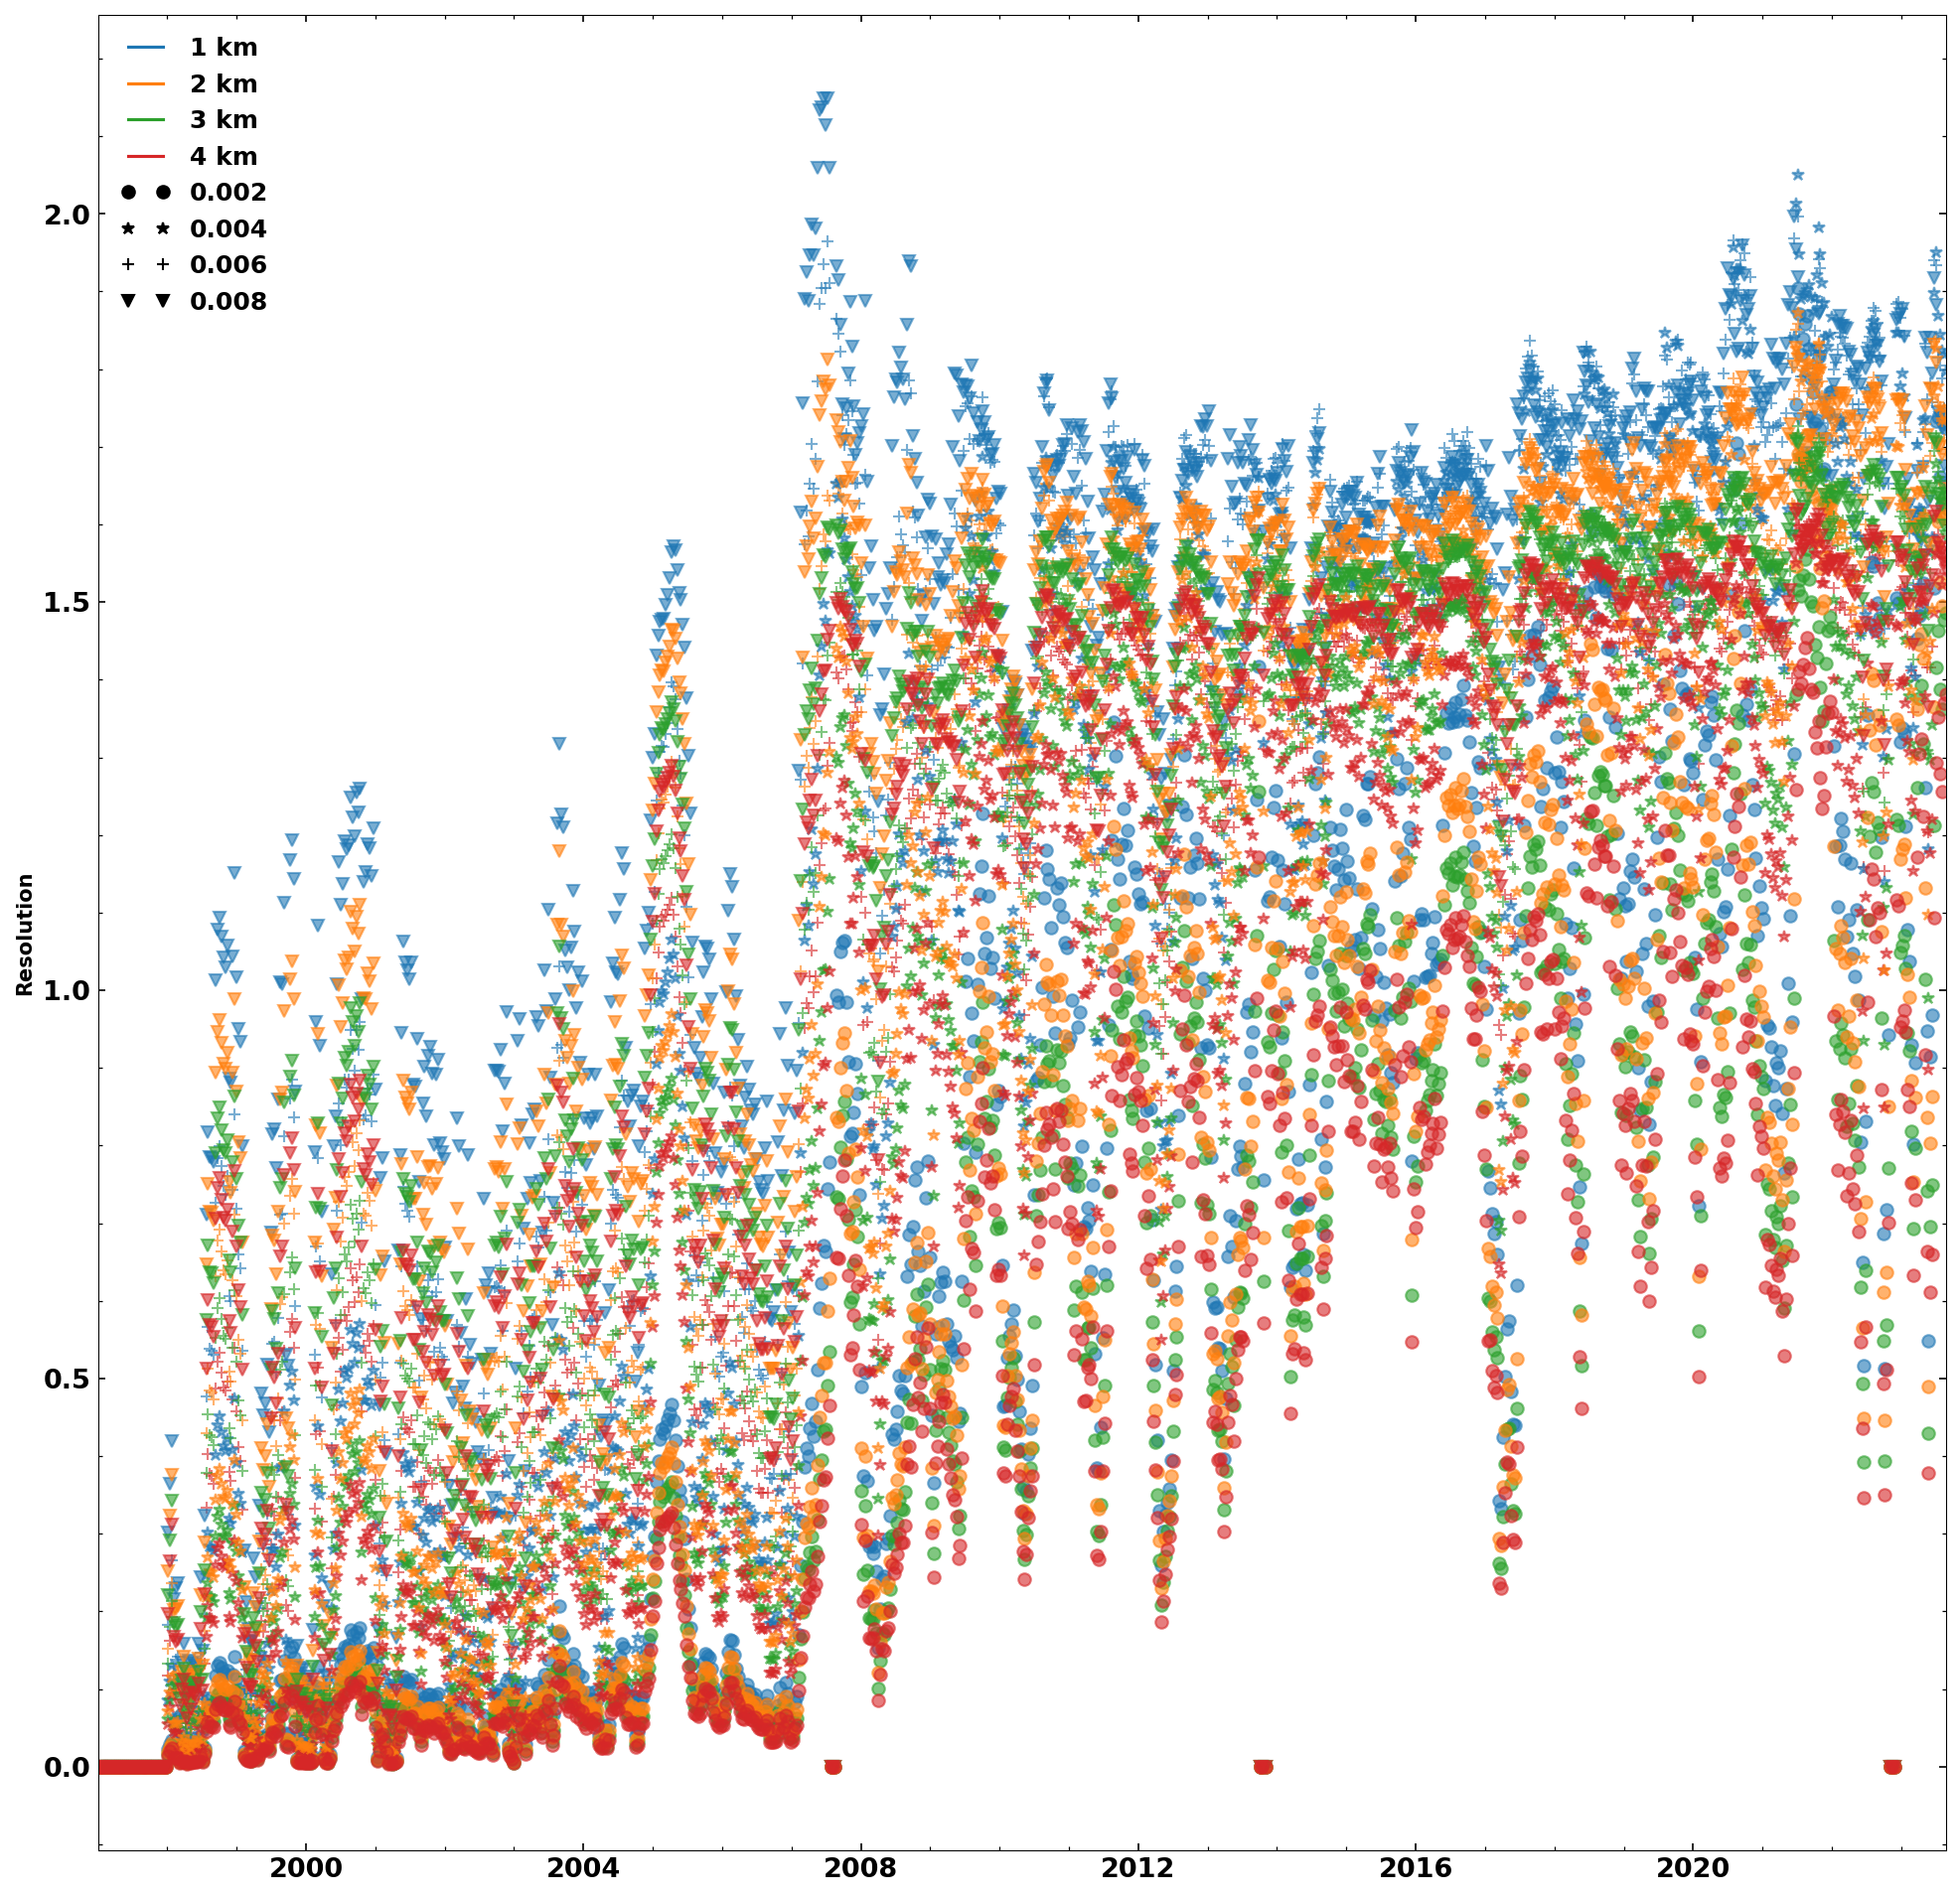

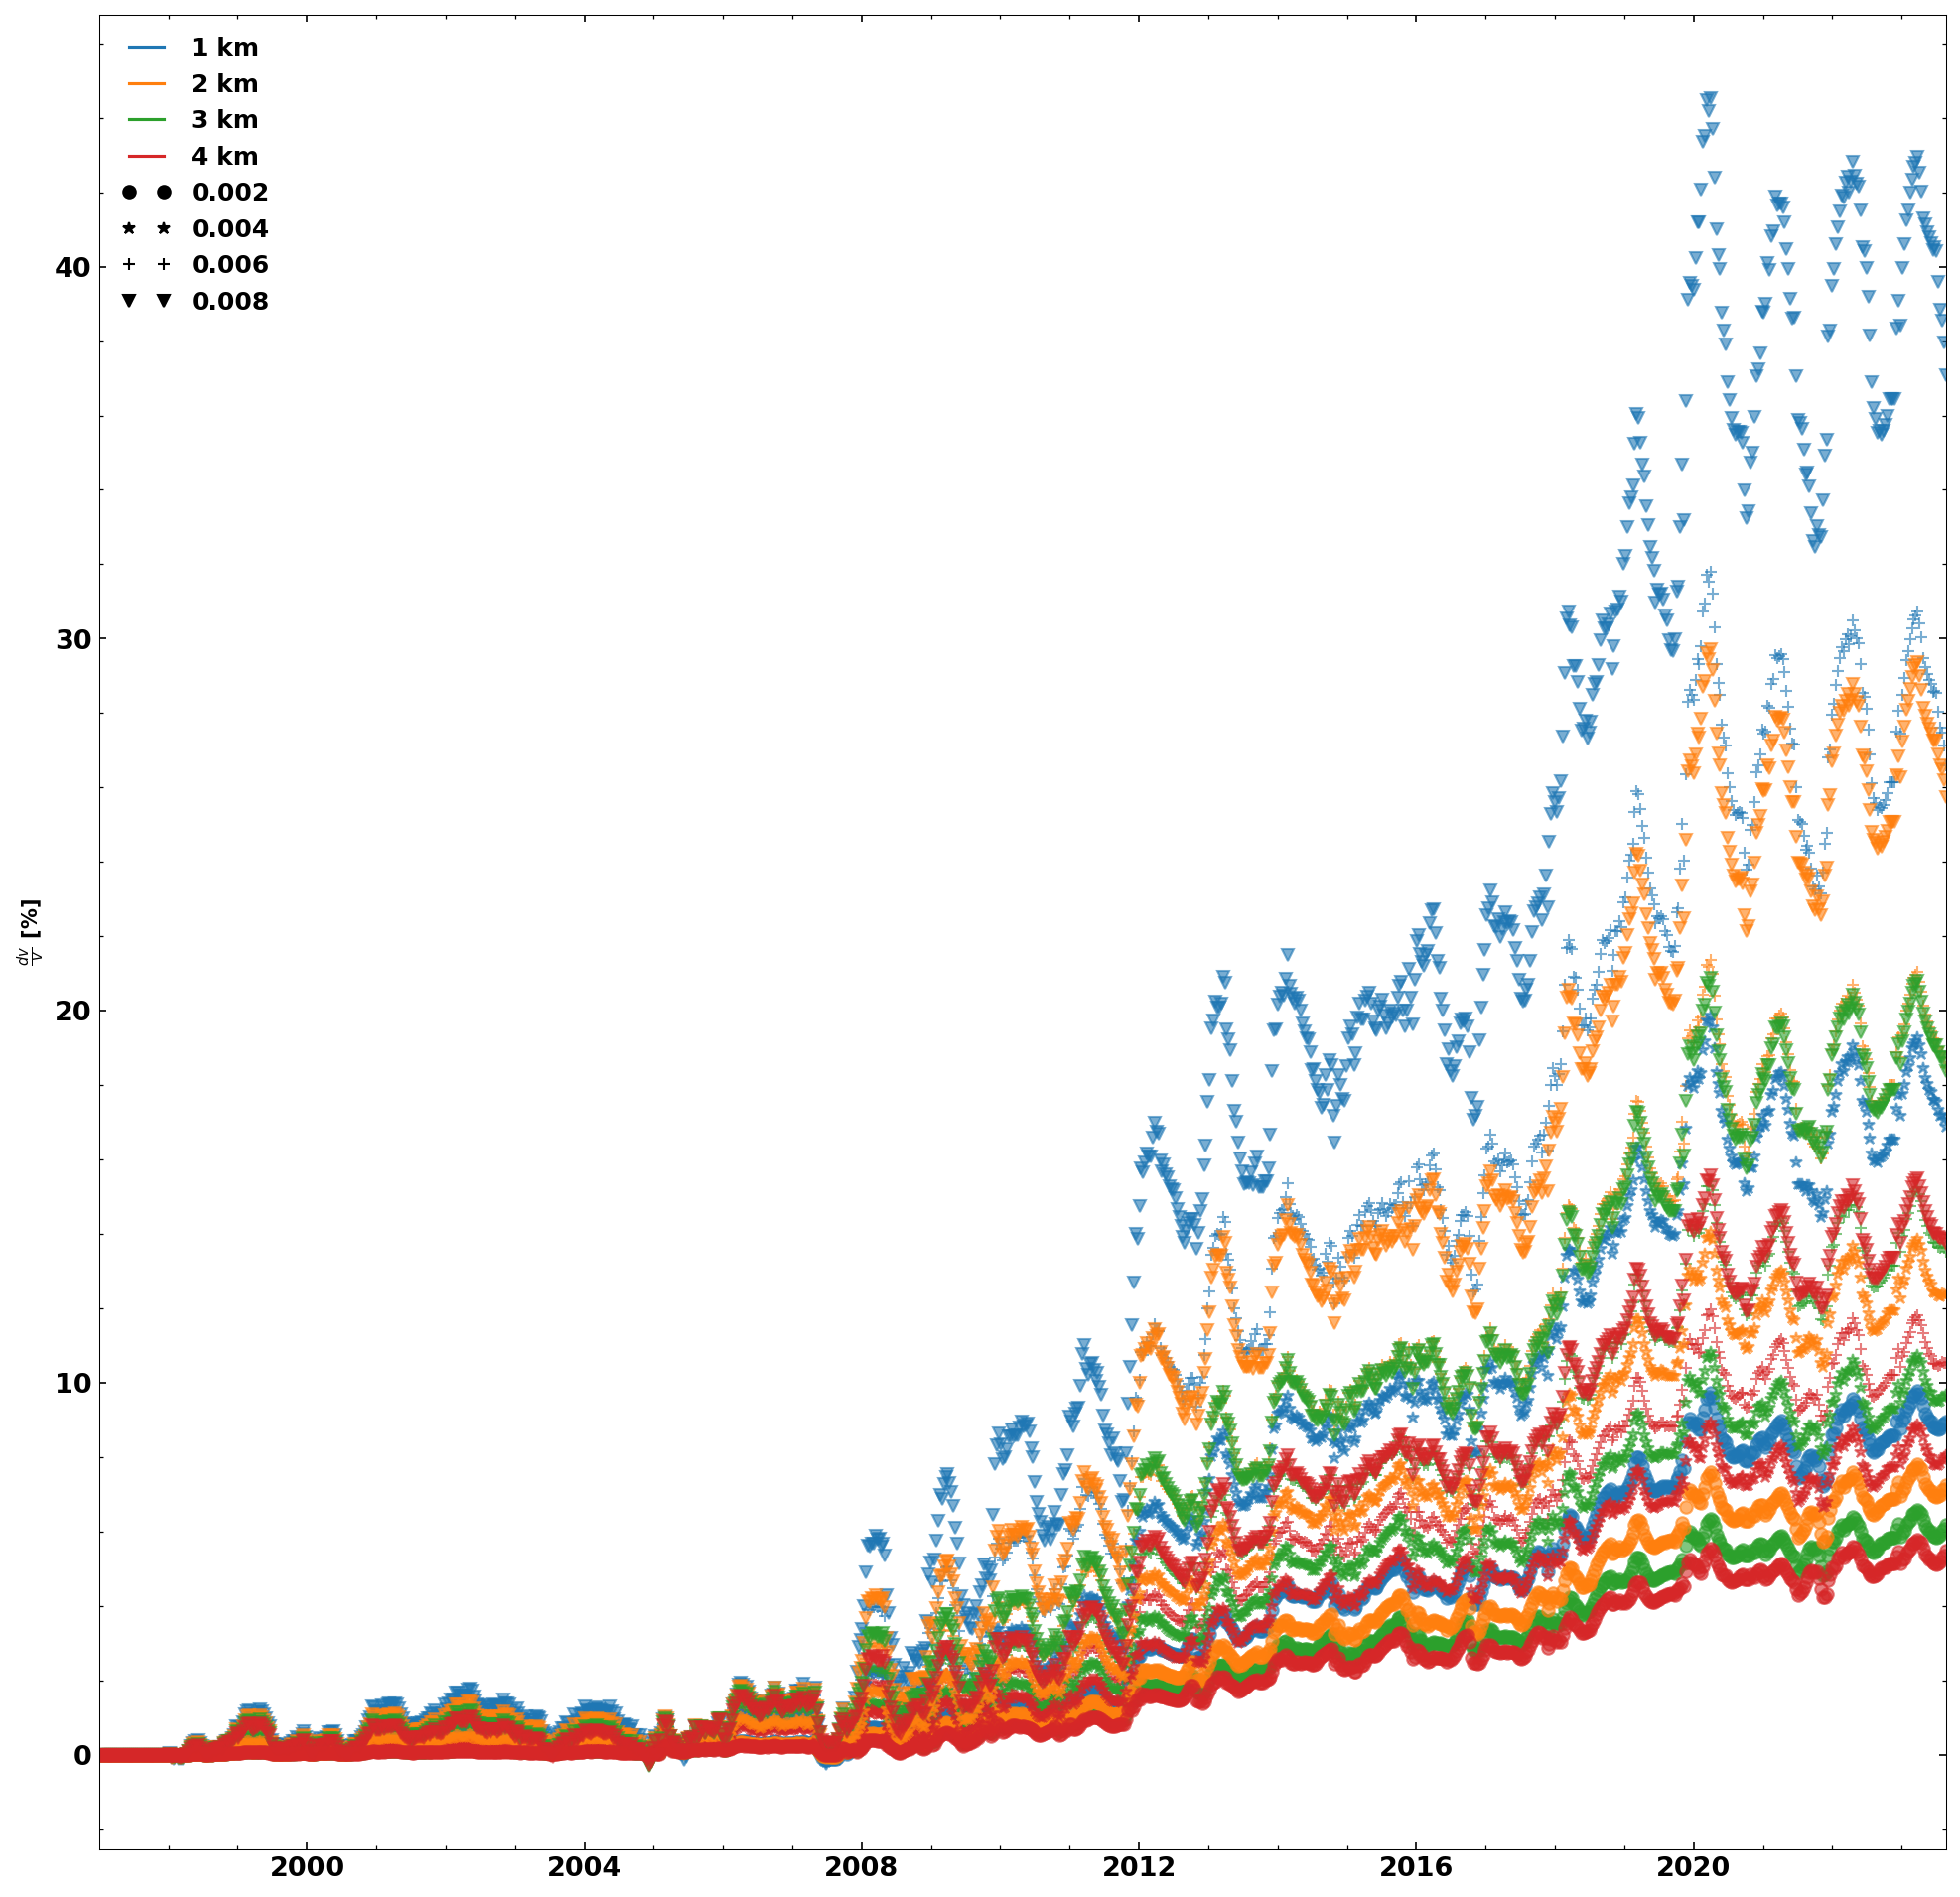

In [ ]:
import glob
import os

import numpy as np
from matplotlib import pyplot as plt
from obspy import UTCDateTime

from seismic.plot.plot_utils import set_mpl_params

set_mpl_params()

freq0 = 1.0
infiles = glob.glob(
    f'/home/pm/Documents_sync/PhD/StHelens/spatial/new_gap_handling_ddt_crosssingle_dvfilt_allcc_cl?_std*_largemap/{freq0}-{freq0*2}/dvdt_3D.npz')
outfolder = '/home/pm/Documents_sync/PhD/StHelens/spatial/param_comparison/allcc_dvfilt'
os.makedirs(outfolder, exist_ok=True)

ax0, ax1 = None, None
fig0, fig1 = None, None

# make colors dependent on the correlation length
# make markers dependent on the standard deviation of the model
# 4 colours, 4 shapes
colordict = {1: 'C0', 2: 'C1', 3: 'C2', 4: 'C3'}
linestyle = {2e-3: 'o{c}', 4e-3: '*{c}', 6e-3: '+{c}', 8e-3: 'v{c}'}

# other option, plot as scatter plot
marker = {2e-3: 'o-', 4e-3: '*', 6e-3: '+', 8e-3: 'v'}



for infile in infiles:
    infile2 = os.path.join(os.path.dirname(infile), 'resolution.npz')
    corr_len = int(infile.split('_cl')[1][0])
    std_model = float(infile.split('_std')[1].split('_')[0])
    # load the actual data
    loaded = np.load(infile)
    loaded2 = np.load(infile2)
    x = loaded['xaxis']
    y = loaded['yaxis']
    t = loaded['taxis']
    date = [UTCDateTime(_t).datetime for _t in t]
    dvdt = loaded['dv']
    dv = np.nancumsum(dvdt, axis=-1)
    statx = loaded['statx']
    staty = loaded['staty']
    res = np.nan_to_num(loaded2['resolution'])
    fig0 = fig0 or plt.figure(figsize=(16, 16))
    ax0 = ax0 or plt.gca()
    # ax0.plot(
    #     date, res[18, 11], color=colordict[corr_len],
    #     linestyle=linestyle[std_model])
    ax0.plot(
        date, res[18, 11], linestyle[std_model].format(c=colordict[corr_len]),
        alpha=0.6)
    # ax0.scatter(
    #     date, res[18,11], color=colordict[corr_len],
    #     marker=marker[std_model], s=3, alpha=.6
    # )
    fig1 = fig1 or plt.figure(figsize=(16, 16))
    ax1 = ax1 or plt.gca()
    ax1.plot(
        date, -100*dv[18, 11], linestyle[std_model].format(c=colordict[corr_len]),
        alpha=0.6)
    # ax1.plot(
    #     date, -100*dv[18, 11], color=colordict[corr_len],
    #     linestyle=linestyle[std_model])
    # ax1.scatter(
    #     date, -100*dv[18, 11], color=colordict[corr_len],
    #     marker=marker[std_model], s=3, alpha=.6,
    # )
ax0.set_ylabel('Resolution')
ax1.set_ylabel(r'$\frac{dv}{v}$ [%]')
# make legends
for corr_len, color in colordict.items():
    ax0.plot([], [], color=color, label=f'{corr_len} km')
    ax1.plot([], [], color=color, label=f'{corr_len} km')
    # ax0.scatter([], [], color=color, label=f'{corr_len} km')
    # ax1.scatter([], [], color=color, label=f'{corr_len} km')
for std_model, linestyle in linestyle.items():
    ax0.plot(
        [], [], linestyle.format(c='k'), label=f'{std_model}')
    # ax0.scatter([], [], color='k', marker=marker[std_model], label=f'{std_model}')
    ax1.plot(
        [], [], linestyle.format(c='k'), label=f'{std_model}')
    # ax1.scatter([], [], color='k', marker=marker[std_model], label=f'{std_model}')
ax0.legend()
ax1.legend()
# ax0.set_ylim((0, 1.05*max(res[18,11])))
ax0.set_xlim((min(date), max(date)))

# ax1.set_ylim((105*min(-dv[18,11]), 105*max(-dv[18,11])))
ax1.set_xlim((min(date), max(date)))


fig0.savefig(os.path.join(outfolder, f'{freq0}_resolution.png'), dpi=300)
fig1.savefig(os.path.join(outfolder, f'{freq0}_dv.png'), dpi=300)



### Resolution

In [16]:
import glob

import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from obspy import UTCDateTime


freq0 = 0.5

infile = glob.glob(f'/home/pm/Documents_sync/PhD/StHelens/spatial/new_gap_handling_ddt_crosssingle_cl1_std0.00_largemap/{freq0}-{2*freq0}/resolution.npz')[0]
infile2 = glob.glob(f'/home/pm/Documents_sync/PhD/StHelens/spatial/new_gap_handling_ddt_crosssingle_cl3_std0.002_largemap/{freq0}-{2*freq0}/resolution.npz')[0]


loaded = np.load(infile)

x = loaded['xaxis']
y = loaded['yaxis']
t = loaded['taxis']
res = np.nan_to_num(loaded['resolution'])

loaded2 = np.load(infile2)
res2 = np.nan_to_num(loaded2['resolution'])

statx = loaded['statx']
staty = loaded['staty']
# No data anymore from this date on
start = 0  # 4 for february # Start here for February
end = -1
# t = t[start:end]

utcs = [UTCDateTime(tt) for tt in t]



# Name suffix for output figure
output_param = '2003-2008'

plt.imshow(np.mean(res, axis=-1))
plt.colorbar()

IndexError: list index out of range

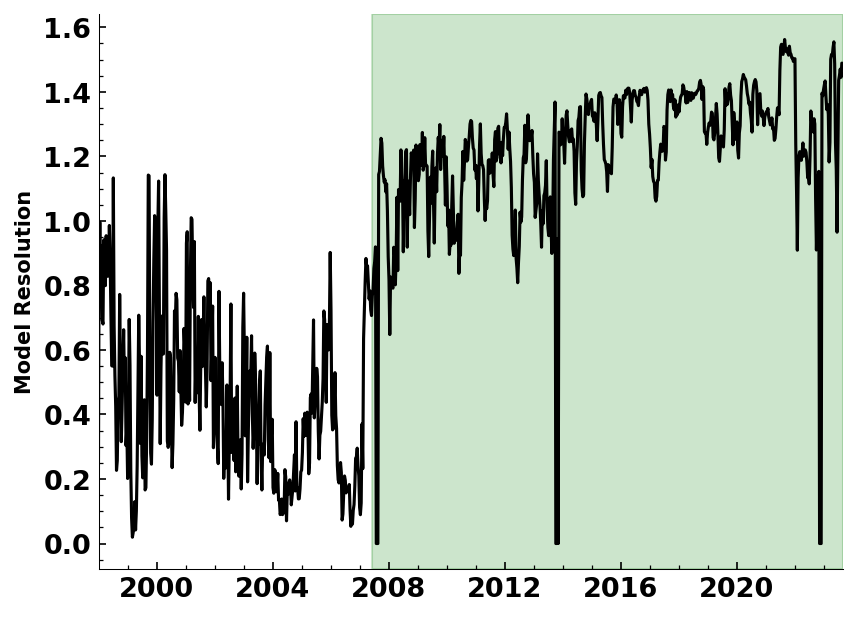

In [27]:
from seismic.plot.plot_utils import set_mpl_params
set_mpl_params()

date = [UTCDateTime(tt).datetime for tt in t]


# plt.plot(date, np.max(np.reshape(res, (-1, len(date))), axis=0))
# plt.plot(date, res[18, 11], 'k')
plt.plot(date, res2[18, 11], 'k')

plt.ylabel('Model Resolution')
# plt.gca().yaxis.label.set_color('blue')


# plt.twinx()
# plt.ylabel('dv/v [%]')
# # color this y-label red
# plt.gca().yaxis.label.set_color('red')
# plt.plot(datetimes, -100*dv[18, 11, :], color='red', label=r'$\frac{dv}{v}$')# print(res.shape, t.shape)
# plt.savefig(os.path.join(outfolder, f'resolution_{output_param}_{freq0}.pdf'), bbox_inches='tight', transparent=True)
# plt.legend()
# green background color from June 2007 on
plt.axvspan(
    datetime.datetime(2007, 6, 1), max(date),
    color='green', alpha=0.2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# turn off ticks where there is no spine
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')
plt.xlim(datetime.datetime(1998, 1, 1), max(date))

plt.savefig('/home/pm/Documents_sync/PhD/conferences/AGU23/poster/res_time_series.png', dpi=300, transparent=True, bbox_inches='tight')


In [ ]:
# interpolate the data from the algorithm, back onto lat and lon
from obspy.geodetics import kilometer2degrees as km2d
from obspy.geodetics import degrees2kilometers as d2km
from obspy.geodetics import locations2degrees as loc2d
from xarray import DataArray
import pygmt


lat = km2d(y)
lat0 = lat.min()
lon0 = -122.45
# find out how many degree 1km is
km2lon = 1/d2km(loc2d(lat0, 1, lat0, 0))
lon = km2lon*(x-x.min())+lon0

region = [lon.min(), lon.max(), lat.min(), lat.max()]
topo = pygmt.datasets.load_earth_relief(resolution="03s", region=region)


pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from -122.022384584 to -122.021666667
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from 46.3647625621 to 46.365


In [ ]:
from scipy.interpolate import RegularGridInterpolator

latq = topo.coords['lat'].data
lonq = topo.coords['lon'].data


lonqg, latqg = np.meshgrid(lonq, latq)
qcoords = np.array([np.array([la, lo]) for lo, la in zip(lonqg.flatten(), latqg.flatten())])

# f = RegularGridInterpolator((lat, lon), res, bounds_error=False, method='linear')

# dv_totalint = f(qcoords)
# dv_totalint = dv_totalint.reshape(latqg.shape)

# dv_total_grid = DataArray(data=res, coords={'lon': lonq, 'lat': latq}, dims=('lat', 'lon'), name='dv/v')


In [ ]:
# pygmt.config() #'13p')
import os
import pandas as pd

stats = pd.read_csv('stat_locs.txt', sep='|', header=0, skipinitialspace=True)

for ii, utc in enumerate(date):
    # compute once every 60 days
    if ii%6 != 0:
        continue
    # find active stations
    slon = [
        lo for lo, stt, et in zip(
        stats.Longitude, stats.StartTime, stats.EndTime) if UTCDateTime(stt) < utc < UTCDateTime(et)]
    slat = [
        lo for lo, stt, et in zip(
        stats.Latitude, stats.StartTime, stats.EndTime) if UTCDateTime(stt) < utc < UTCDateTime(et)]
    f = RegularGridInterpolator((lat, lon), res[:, :, ii], bounds_error=False, method='linear')
    res_now = f(qcoords)
    res_now = res_now.reshape(latqg.shape)
    # res_int_grid = DataArray(data=res_int[:, :, ii], coords={'lon': lonq, 'lat': latq}, dims=('lat', 'lon'), name='dv/v')# , indexes=[lon, lat])
    res_int_grid = DataArray(data=res_now, coords={'lon': lonq, 'lat': latq}, dims=('lat', 'lon'), name='res')# , indexes=[lon, lat])

    fig = pygmt.Figure()
    # create colorbar for xarray.DataArray
    pygmt.makecpt(
        cmap="viridis",
        series=f"0/2",
        continuous=True,
        reverse=False,
    )

    persp = [160, 50]
    proj = "M30c"

    with pygmt.config(
        MAP_FRAME_TYPE='fancy+', FORMAT_GEO_MAP='ddd.xx',
        # MAP_GRID_CROSS_SIZE_PRIMARY=0.20,
        # MAP_GRID_CROSS_SIZE_SECONDARY=0.20,
        # MAP_TICK_LENGTH_PRIMARY=0.5,
        # MAP_TICK_LENGTH_SECONDARY=0.5,
        # FONT_ANNOT_PRIMARY='18p,Helvetica-Bold',
        # FONT_ANNOT_SECONDARY='18p,Helvetica-Bold',
        FONT='25p,Helvetica-Bold'):
        fig.grdview(
            grid=topo,
            drapegrid=res_int_grid,
            # Sets the view azimuth as 130 degrees, and the view elevation as 30
            # degrees
            perspective=persp, #160 50
            # cmap='turbo',
            region=region,
            # Sets the x- and y-axis labels, and annotates the west, south, and east
            # axes
            frame=["xa", "ya", "WSnE"],
            surftype='sm',#m0.01p',
            # cmap='rainbow',
            # plane="2000+gblack",
            # Sets a Mercator projection on a 15-centimeter figure
            projection=proj,
            # Sets the height of the three-dimensional relief at 1.5 centimeters
            zsize="2c",
            meshpen="0.1p",
            transparency=20
        )
        fig.colorbar(frame=['a0.25', "x+ldv/v", "y+l[%]"],perspective=persp, projection=proj)
        fig.plot(
            x=slon, y=slat, style="i0.7c", color="red", pen="black", transparency=25, perspective=persp, projection=proj)
    os.makedirs(f'{outfolder}/resolution_maps', exist_ok=True)
    fig.savefig(f'{outfolder}/resolution_maps/{freq0}-{freq0*2}_{utc.date()}.png', dpi=100, transparent=True)

makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)
makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)
makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)
makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)
makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)
makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)
makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)
makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)
makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)
makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)
makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)
makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)
makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)
makecpt [WARNING]: Without inc in -T option, -Z has no effect (i

# Local quakes
check for correlations in the dv/v trend and the number of earthquake occurences (and their depths)

In [4]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy.core.event.catalog import Catalog
import numpy as np
from obspy import read_events


minmag = 0
try:
    evts = read_events(f'MSH_events_minmag{minmag}.xml')
except FileNotFoundError:
    c = Client('USGS', timeout=240)

    lat = [45.95, 46.45]
    lon = [-122.45, -121.96]


    starttime = UTCDateTime(year=2007, julday=1)
    endtime = UTCDateTime(year=2023, julday=300)
    delta = 86400*365
    rtimes = np.linspace(starttime.timestamp, endtime.timestamp, 12)
    # rtimes = np.arange(starttime.timestamp, endtime.timestamp, delta)
    evts = Catalog()



    for ii, rtime in enumerate(rtimes):
        if ii == len(rtimes)-1:
            break
        start = UTCDateTime(rtime)
        end = UTCDateTime(rtimes[ii+1])
        print(f'downloading events from {start} to {end}')
        evts.extend(c.get_events(
            starttime=start, endtime=end, minmagnitude=minmag, maxdepth=15,
            minlatitude=lat[0], maxlatitude=lat[1], minlongitude=lon[0],
            maxlongitude=lon[1]))
    evts.write(f'MSH_events_minmag{minmag}.xml', format='QUAKEML')

otimes = [evt.preferred_origin().time.datetime for evt in evts]
hypz = [-evt.preferred_origin().depth for evt in evts]


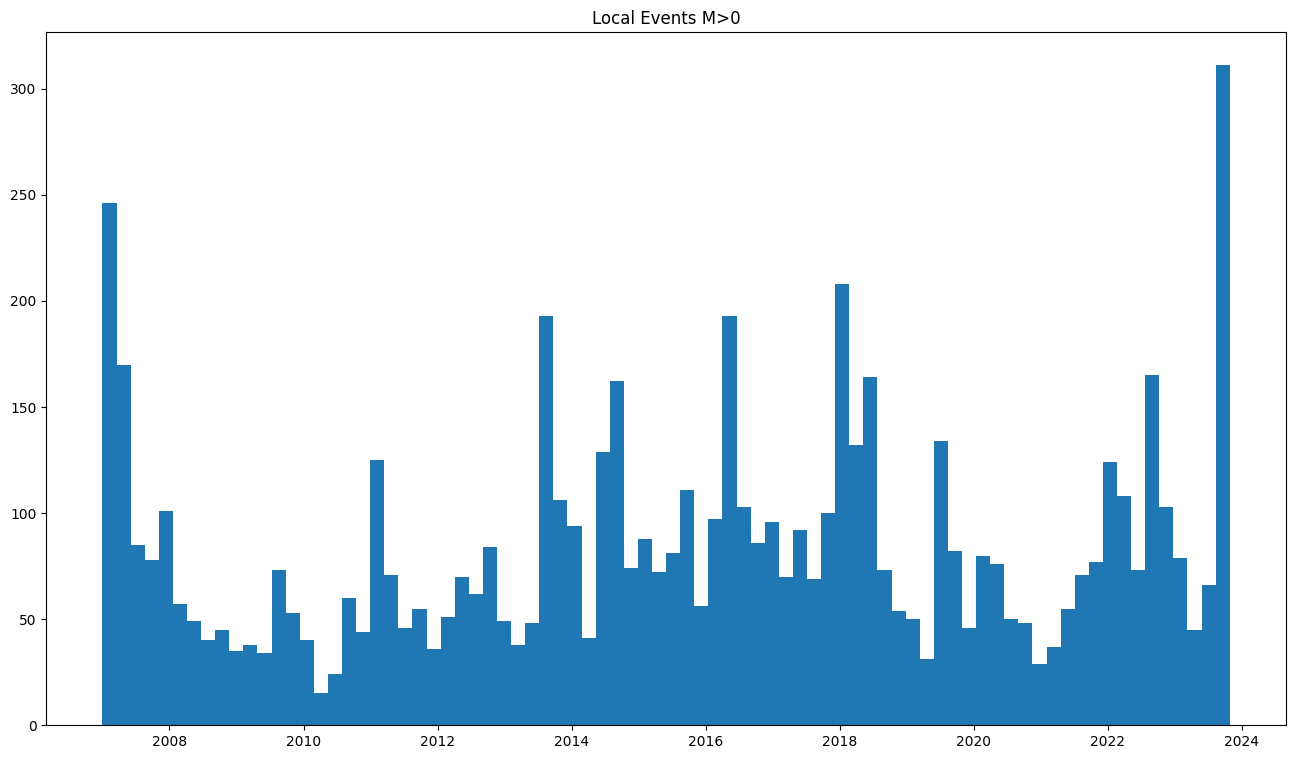

In [5]:
import os
from matplotlib import pyplot as plt

plt.figure(figsize=(16,9))
plt.hist(otimes, 80)
os.makedirs('../figures/events/', exist_ok=True)
plt.title(f'Local Events M>{minmag}')
plt.savefig('../figures/events/event_distr.pdf',facecolor='none')

### plot events vs dv/v curve

In [18]:
# load dv/v data for all frequencies
import glob
import os

import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from obspy import UTCDateTime


freq0 = 0.5
corr_len = 3
std_model = 0.002
dv = {}
for freq0, std_model in zip([0.25, 0.5, 1.0], [0.008, 0.002, 0.004]):
    infile = glob.glob(
        f'/home/pm/Documents_sync/PhD/StHelens/spatial/new_gap_handling_ddt_crosssingle_dvfilt_allcc_cl{corr_len}_std{std_model}_largemap/{freq0}-{freq0*2}/dvdt_3D.npz')[0]

    loaded = np.load(infile)

    x = loaded['xaxis']
    y = loaded['yaxis']
    t = loaded['taxis']
    dvdt = loaded['dv']

    start = np.argmin(abs(t - UTCDateTime('2007-06-01').timestamp))
    t = t[start:]
    dv[freq0] = -100*np.nancumsum(dvdt[15, 19, start:], axis=-1)
datetimes = [UTCDateTime(tt).datetime for tt in t]


In [19]:
from obspy.signal.filter import highpass
from scipy.signal import detrend
# Filter dv signals
dv_hpf = {}
for freq0 in [0.25, 0.5, 1.0]:
    dv_1d = detrend(dv[freq0])
    df = 1/(datetimes[1]-datetimes[0]).total_seconds()
    filtfreq = 1/(2*365.25*24*60*60)
    dv_hpf[freq0] = highpass(dv_1d, filtfreq, df, corners=4, zerophase=True)

In [20]:
# compute accumulated moment release in each depth zone

# depth zones depend on the frequency and velocity
vel = 2500
depthzones = {}
for freq0 in [0.25, 0.5, 1.0]:
    depthzones[freq0] = np.arange(0, 2000, 2/3*vel/freq0)
depthzones = np.flip([2000, -2/3*vel+1500, -2/3*vel/0.5+1500, -2/3*vel/0.25+1500])
print(depthzones)

seismic_moment = np.zeros((len(depthzones)-1, len(datetimes)))

# obtain the seismic moment for each event and timestep
for dateidx, date in enumerate(datetimes):
    filt_evts = [evt for evt in evts if abs(evt.preferred_origin().time.datetime-date) < (datetimes[1]-datetimes[0])/2]
    for freq0 in [0.25, 0.5, 1.0]:
        for evt in filt_evts:
            # find the depth zone in which the event occurs
            depth = -evt.preferred_origin().depth
            if depth < depthzones.min() or depth > depthzones.max():
                continue
            depthzone = depthzones[depthzones>=depth].min()
            # find the index of the depth zone
            depthzone_idx = np.where(depthzones==depthzone)[0][0]-1
            # compute the seismic moment
            seismic_moment[depthzone_idx, dateidx] += 10**(1.5*evt.preferred_magnitude().mag+9.1)

# accumulated seismic moment
acc_seismic_moment = np.cumsum(seismic_moment, axis=-1)

[-5166.66666667 -1833.33333333  -166.66666667  2000.        ]


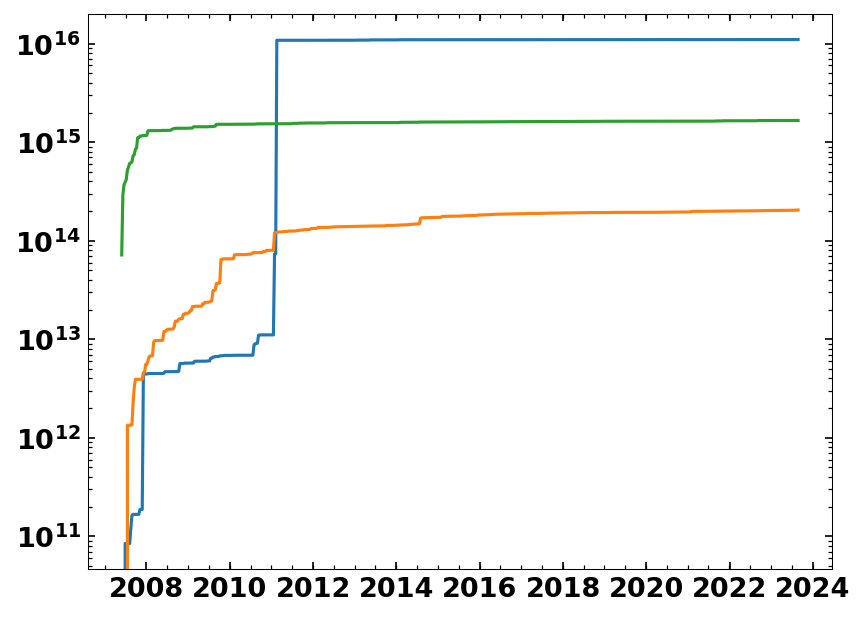

In [21]:
plt.plot(datetimes, acc_seismic_moment[0])
plt.plot(datetimes, acc_seismic_moment[1])
plt.plot(datetimes, acc_seismic_moment[2])
# y-axis logarithmic
plt.yscale('log')

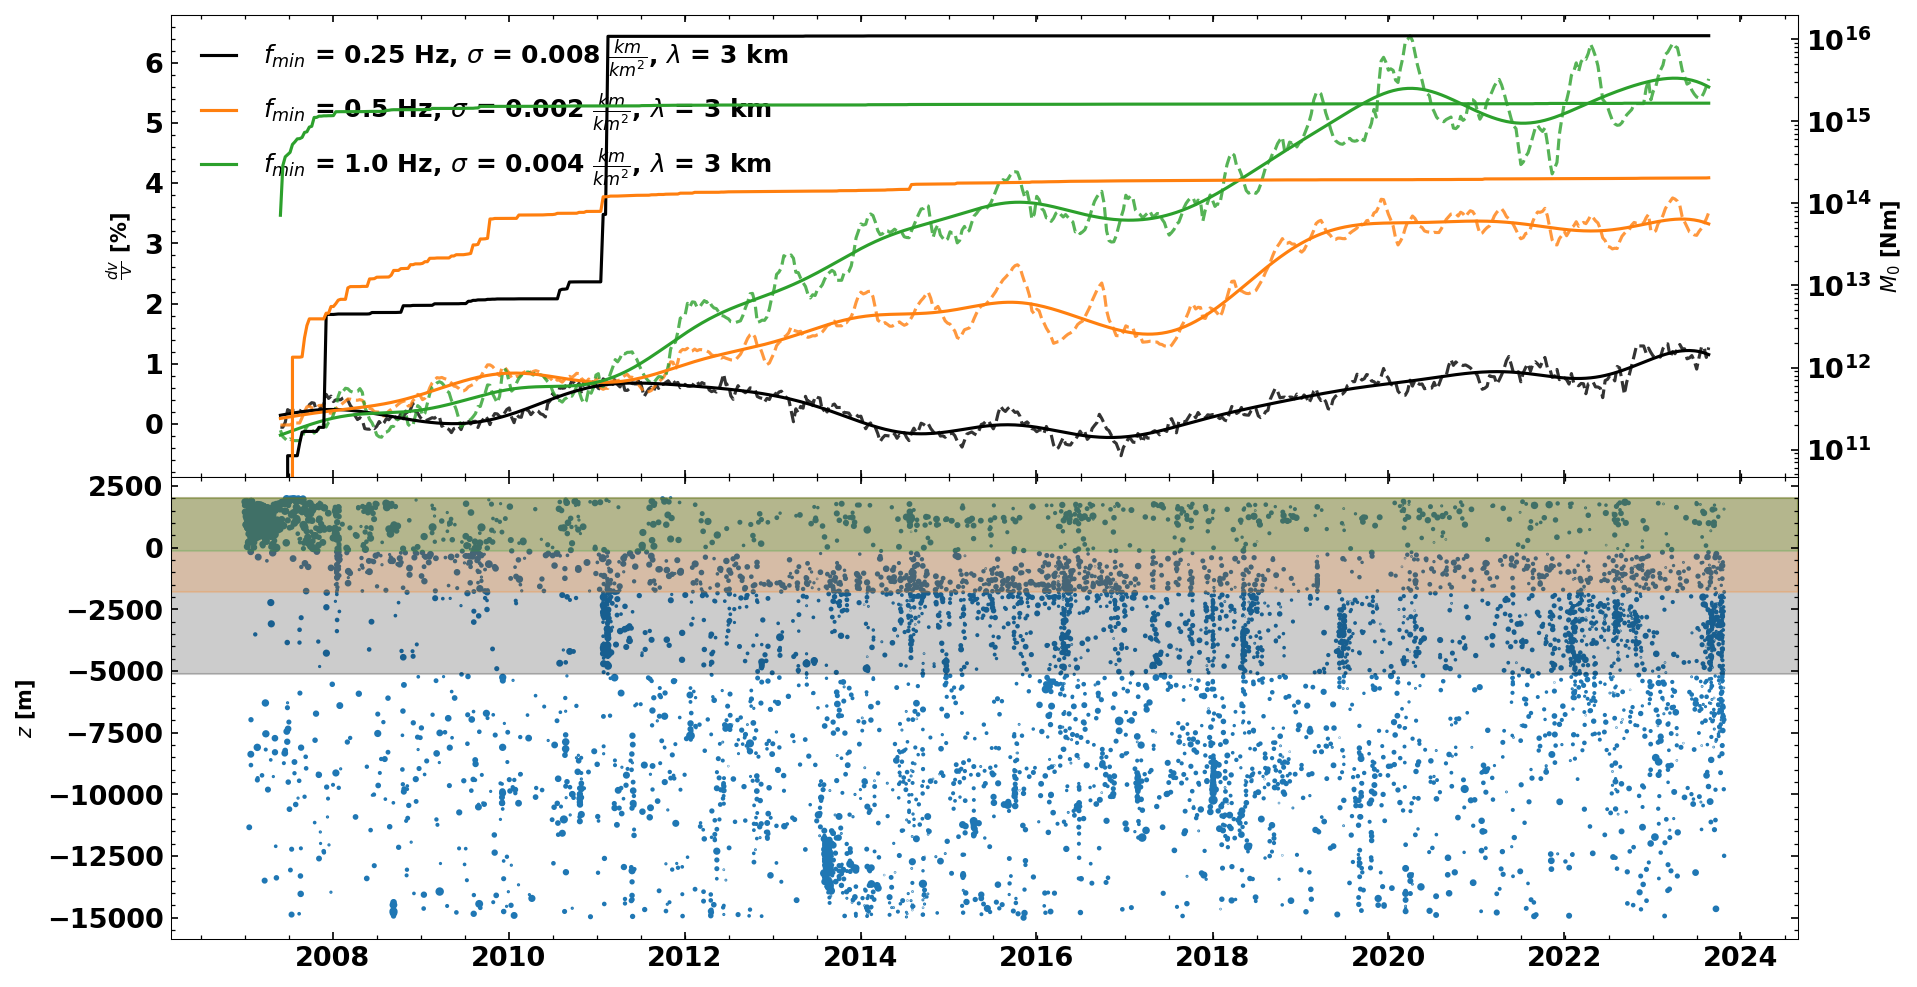

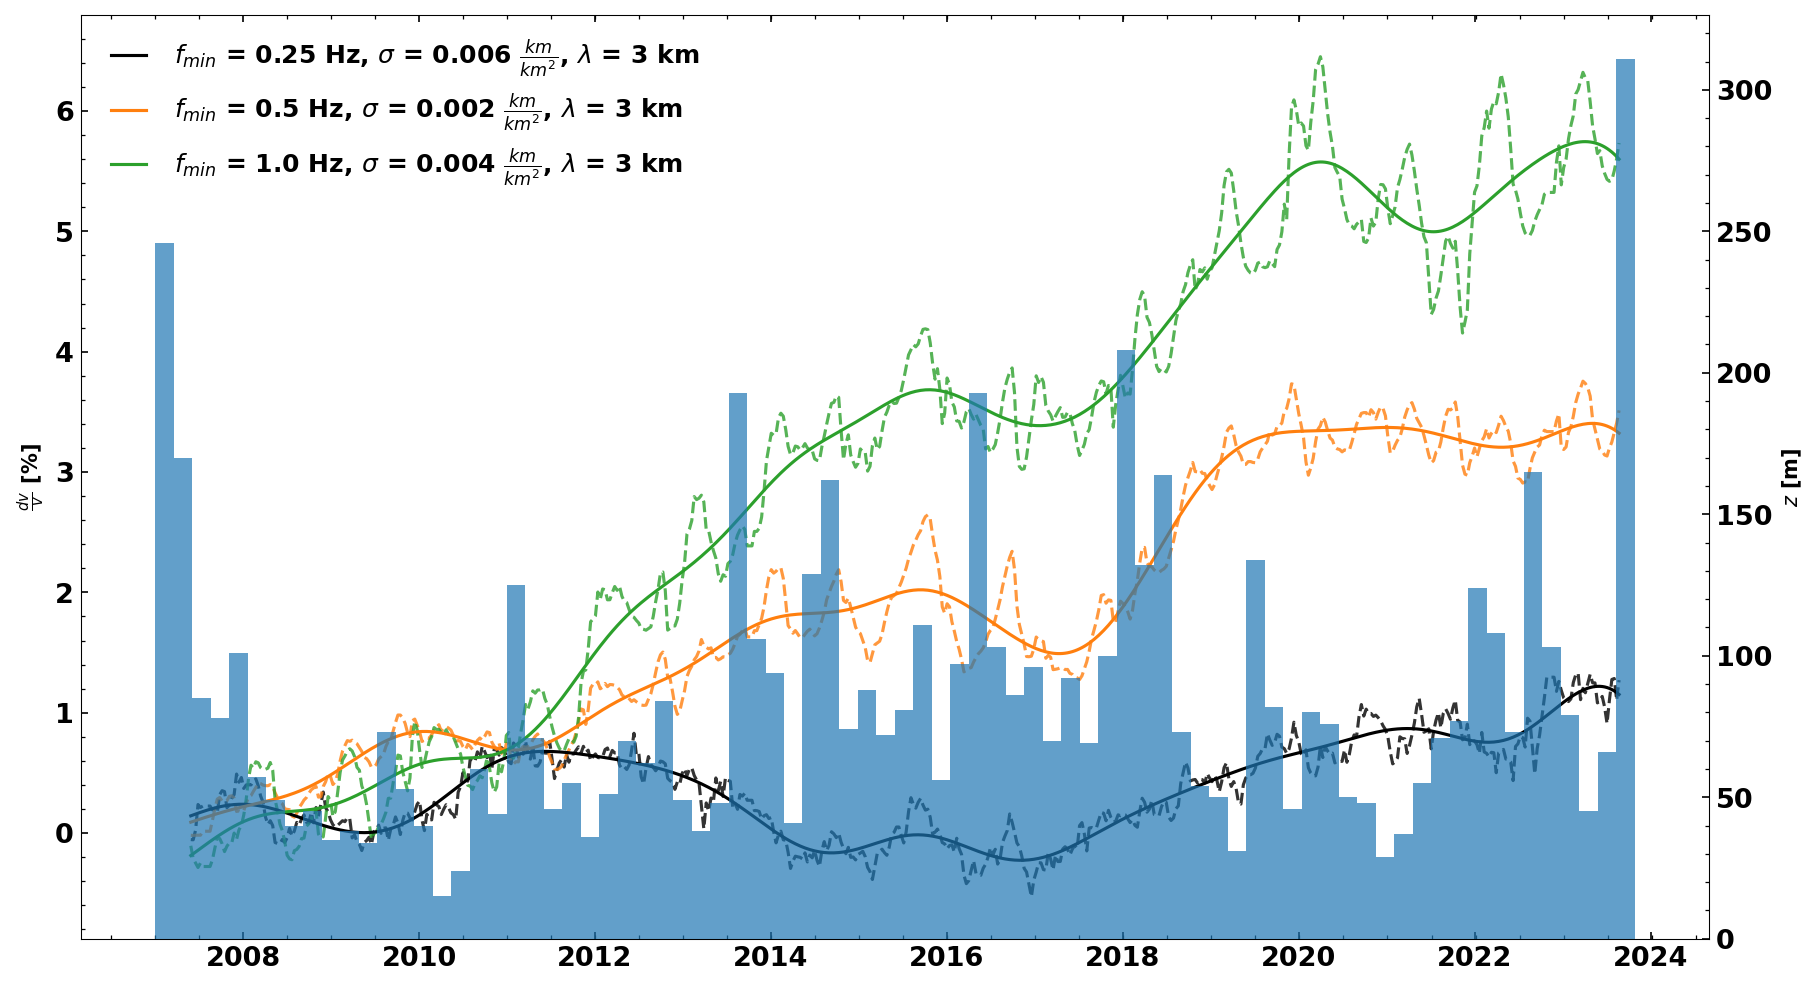

In [23]:
from seismic.plot.plot_utils import set_mpl_params
set_mpl_params()

outfolder = os.path.join(os.path.dirname(os.path.dirname(infile)), 'figures')

# plot dv/v for all frequencies

# # difference
plt.figure(figsize=(14, 8))
ax0 = plt.subplot(2,1,1)
colors = ['k', 'C1', 'C2']
for freq0, std_model, col in zip(
        [0.25, 0.5, 1.0], [0.008, 0.002, 0.004], colors):
    plt.plot(
        datetimes, dv[freq0]-dv_hpf[freq0], label=r'$f_{min}$ = '+f'{freq0} Hz, '+r'$\sigma$ = '+f'{std_model} '+r'$\frac{km}{km^2}$, $\lambda$ = 3 km', color=col,zorder=5)
    # plt.plot(
    #     datetimes[1:], np.diff(dv[freq0]-dv_hpf[freq0]), color=col,zorder=5)
    plt.plot(
        datetimes, dv[freq0], linestyle='--', alpha=0.8, color=col,zorder=2)
plt.ylabel(r'$\frac{dv}{v}$ [%]')
plt.legend()

plt.twinx()
# plt.hist(otimes, 80, alpha=0.7, zorder=1);
# plt.ylabel(r'$N_{evts}$')
# plot accumulated seismic moment
for ii, col in enumerate(colors):
    plt.plot(
        datetimes, acc_seismic_moment[ii], color=col, zorder=0)
plt.ylabel(r'$M_0$ [Nm]')
plt.yscale('log')

ax1 = plt.subplot(2,1,2, sharex=ax0)
plt.ylabel(r'$z$ [m]')

# plot earthquake depths
hypz = [-evt.preferred_origin().depth for evt in evts]
plt.scatter(otimes, hypz, s=[evt.preferred_magnitude().mag*3 for evt in evts])


# mark sensitivity ranges as shaded areas
# maximum sensitivity is 2/3 waveflength below surface
vel = 2500
for freq0, std_model, col in zip(
        [0.25, 0.5, 1.0], [0.008, 0.002, 0.004], colors):
    plt.axhspan(
        max(hypz)-2/3*vel/freq0-500, max(hypz), alpha=0.2, color=col, label=f'{freq0} Hz')
# remove the gap between the subplots
plt.subplots_adjust(hspace=0)
# remove upper x-label
plt.setp(ax0.get_xticklabels(), visible=False)

plt.savefig(f'{outfolder}/n_evts_dv_{freq0}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'/home/pm/Documents_sync/PhD/seminars/SPIN seminar/n_evts_dv_{freq0}_depth.png', bbox_inches='tight', facecolor='None')

# as above but only the upper subplot in a single figure
plt.figure(figsize=(14, 8))
colors = ['k', 'C1', 'C2']
for freq0, std_model, col in zip(
        [0.25, 0.5, 1.0], [0.006, 0.002, 0.004], colors):
    plt.plot(
        datetimes, dv[freq0]-dv_hpf[freq0], label=r'$f_{min}$ = '+f'{freq0} Hz, '+r'$\sigma$ = '+f'{std_model} '+r'$\frac{km}{km^2}$, $\lambda$ = 3 km', color=col,zorder=5)
    # plt.plot(
    #     datetimes[1:], np.diff(dv[freq0]-dv_hpf[freq0]), color=col,zorder=5)
    plt.plot(
        datetimes, dv[freq0], linestyle='--', alpha=0.8, color=col,zorder=2)
plt.ylabel(r'$\frac{dv}{v}$ [%]')
plt.legend()

plt.twinx()
plt.hist(otimes, 80, alpha=0.7, zorder=1);
plt.ylabel(r'$N_{evts}$')

plt.ylabel(r'$z$ [m]')
# plot with transparent canvas
plt.savefig(f'/home/pm/Documents_sync/PhD/seminars/SPIN seminar/n_evts_dv_{freq0}.png', bbox_inches='tight') #, facecolor=None)

